In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Unificado_def_2015_2025.xlsx')

**API - Header y configuración Token para hacer peticiones**




In [ ]:
df

,datetime_utc,geo_id,geo_name,value
0,2014-12-31T23:00:00Z,8741,Península,25459
1,2014-12-31T23:10:00Z,8741,Península,25591
2,2014-12-31T23:20:00Z,8741,Península,25531
3,2014-12-31T23:30:00Z,8741,Península,25453
4,2014-12-31T23:40:00Z,8741,Península,25329
...,...,...,...,...
692580,2025-04-12T16:00:00Z,8741,Península,23274
692581,2025-04-12T16:05:00Z,8741,Península,23627
692582,2025-04-12T16:10:00Z,8741,Península,23741
692583,2025-04-12T16:15:00Z,8741,Península,23749


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

**Exploración de datos EDA**

In [ ]:
df = pd.read_excel("/content/Unificado_def_2015_2025.xlsx") #Cargamos los datos defintivos todos juntos

In [ ]:
data = df[['datetime_utc', 'value']]

In [ ]:
data = data.rename(columns={'datetime_utc': 'datetime'})


In [ ]:
data['datetime_str'] = pd.to_datetime(data['datetime']).dt.tz_localize(None).dt.strftime('%Y-%m-%d %H:%M:%S')


In [ ]:
data = data[['value', 'datetime_str']]

In [ ]:
data = data.rename(columns={'datetime_str': 'datetime'})


In [ ]:
data['datetime'] = data['datetime'].astype(str)
data['datetime'] = data['datetime'].str.split('+').str[0]
data['datetime'] = pd.to_datetime(data['datetime'])

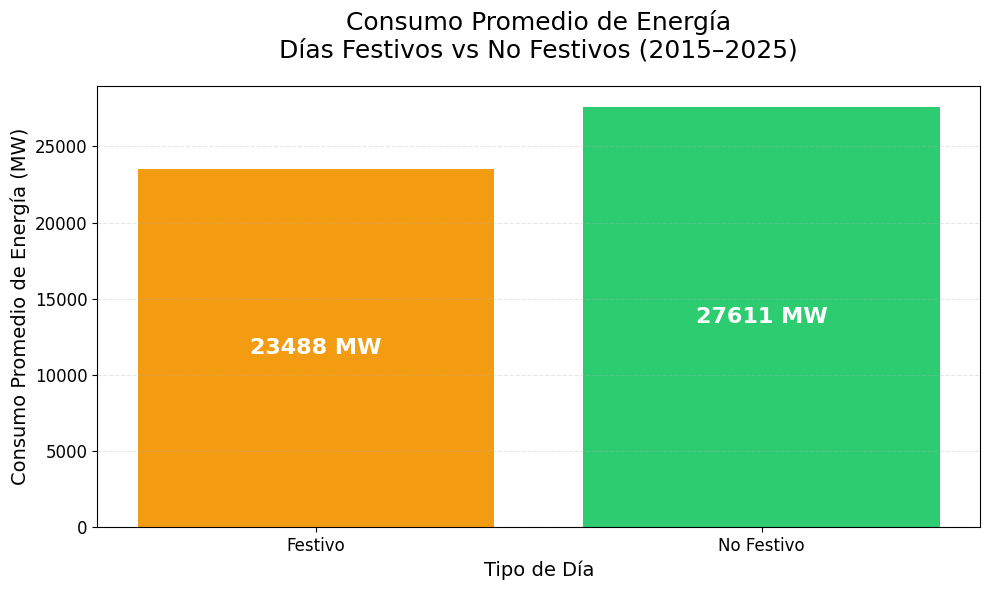

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays

data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

data['fecha'] = data.index.normalize()

festivos_es = holidays.Spain(years=range(2015, 2026))
festivos = pd.to_datetime(list(festivos_es.keys()))

data['tipo_dia'] = data['fecha'].apply(lambda x: 'Festivo' if x in festivos else 'No Festivo')

df_tipo_dia = data.groupby('tipo_dia')['value'].mean()

colores = {'Festivo': '#F39C12', 'No Festivo': '#2ECC71'}

plt.figure(figsize=(10, 6))
bars = plt.bar(df_tipo_dia.index, df_tipo_dia.values, color=[colores[tipo] for tipo in df_tipo_dia.index])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2,
             f'{yval:.0f} MW',
             ha='center', va='center',
             fontsize=16, color='white', fontweight='bold')


plt.title('Consumo Promedio de Energía\nDías Festivos vs No Festivos (2015–2025)', fontsize=18, pad=20)
plt.xlabel('Tipo de Día', fontsize=14)
plt.ylabel('Consumo Promedio de Energía (MW)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


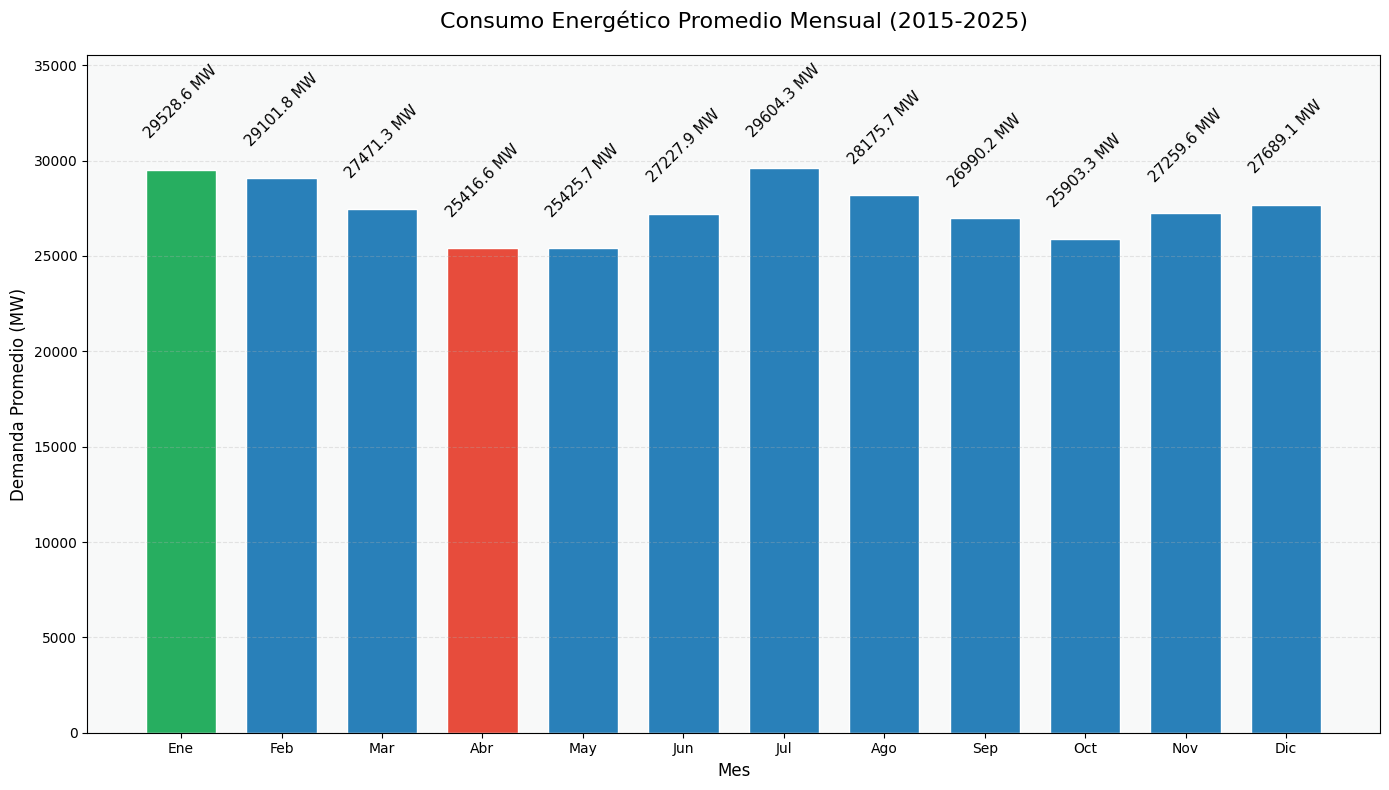

In [ ]:


data['datetime'] = pd.to_datetime(data['datetime'])

data.set_index('datetime', inplace=True)

data['mes'] = data.index.month
consumo_mensual = data.groupby('mes')['value'].mean().reset_index()

meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
consumo_mensual['nombre_mes'] = consumo_mensual['mes'].map(lambda x: meses[x-1])

plt.figure(figsize=(14,8))
colors = ['#E74C3C' if m == 4 else '#27AE60' if m == 1 else '#2980B9'
          for m in consumo_mensual['mes']]

bars = plt.bar(
    consumo_mensual['nombre_mes'],
    consumo_mensual['value'],
    color=colors,
    width=0.7,
    edgecolor='white'
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval + 0.05*max(consumo_mensual['value']),
             f'{yval:.1f} MW',
             ha='center',
             va='bottom',
             rotation=45,
             fontsize=11)

plt.title('Consumo Energético Promedio Mensual (2015-2025)', fontsize=16, pad=20)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Demanda Promedio (MW)', fontsize=12)
plt.ylim(0, max(consumo_mensual['value'])*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().set_facecolor('#F8F9F9')
plt.tight_layout()

plt.show()


In [ ]:
print("Información general del DataFrame:")
print(data.info())

Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692585 entries, 0 to 692584
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   value     692585 non-null  int64         
 1   datetime  692585 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 10.6 MB
None


In [ ]:
print("Primeras filas del DataFrame:")
print(data.head())

Primeras filas del DataFrame:
   value            datetime
0  25459 2014-12-31 23:00:00
1  25591 2014-12-31 23:10:00
2  25531 2014-12-31 23:20:00
3  25453 2014-12-31 23:30:00
4  25329 2014-12-31 23:40:00


In [ ]:
print("Número total de registros y variables:")
print(f"Filas: {data.shape[0]}, Columnas: {data.shape[1]}")

Número total de registros y variables:
Filas: 692585, Columnas: 2


In [ ]:
print("¿Los datos están ordenados cronológicamente?")
print(data.index.is_monotonic_increasing)

¿Los datos están ordenados cronológicamente?
True


In [ ]:
print("Tipo de datos en cada columna:")
print(data.dtypes)

Tipo de datos en cada columna:
value                int64
datetime    datetime64[ns]
dtype: object


In [ ]:
categorical_columns = data.select_dtypes(include=['object']).columns
print("\n📌 Variables categóricas detectadas:")
print(categorical_columns)


📌 Variables categóricas detectadas:
Index([], dtype='object')


In [ ]:
print("Valores nulos:")
print(data.isnull().sum())

Valores nulos:
datetime    0
value       0
dtype: int64


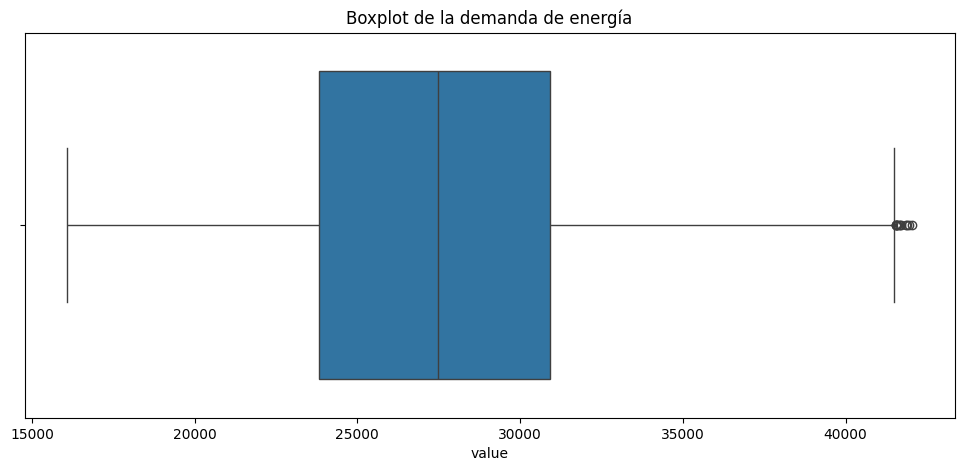

In [ ]:
# Usar boxplot para detectar valores anómalos
plt.figure(figsize=(12,5))
sns.boxplot(x=data['value'])
plt.title("Boxplot de la demanda de energía")
plt.show()

In [ ]:
# Detección de outliers con el método IQR
Q1 = data['value'].quantile(0.25)
Q3 = data['value'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
outliers = data[(data['value'] < (Q1 - 1.5 * IQR)) | (df['value'] > (Q3 + 1.5 * IQR))]
print("\n Cantidad de valores atípicos detectados:", len(outliers))


 Cantidad de valores atípicos detectados: 12


In [ ]:
print("\n📌 Valores atípicos detectados:")
print(outliers)
print(outliers.min())
print(outliers.max())


📌 Valores atípicos detectados:
                        datetime  value
316725 2021-01-08 10:30:00+00:00  41550
316727 2021-01-08 10:50:00+00:00  41551
316732 2021-01-08 11:40:00+00:00  41588
316734 2021-01-08 12:00:00+00:00  41552
316735 2021-01-08 12:10:00+00:00  41885
316736 2021-01-08 12:20:00+00:00  42052
316737 2021-01-08 12:30:00+00:00  41960
316738 2021-01-08 12:40:00+00:00  41867
316739 2021-01-08 12:50:00+00:00  41657
317354 2021-01-12 19:20:00+00:00  41584
317356 2021-01-12 19:40:00+00:00  41699
317357 2021-01-12 19:50:00+00:00  41687
datetime    2021-01-08 10:30:00+00:00
value                           41550
dtype: object
datetime    2021-01-12 19:50:00+00:00
value                           42052
dtype: object


Valores Atípicos, 24 de casi medio millón de registros. Rango [43650 - 44153]

*   Elemento de lista

*   Elemento de lista
*   Elemento de lista


*   Elemento de lista



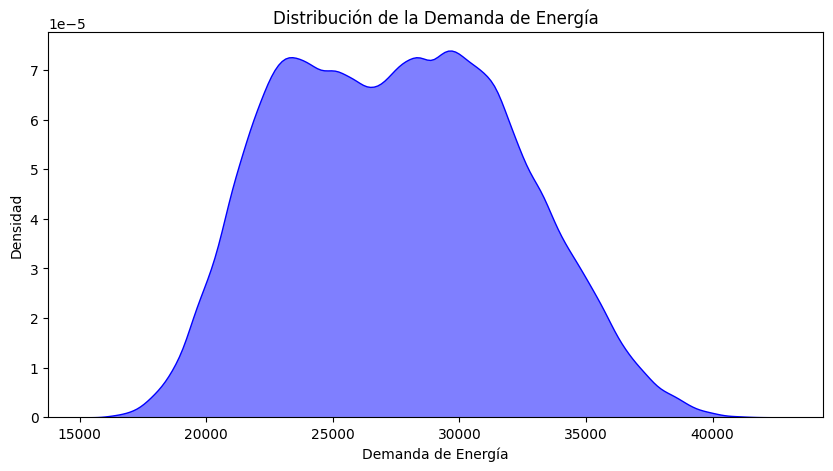

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Graficar la densidad de la demanda de energía
plt.figure(figsize=(10, 5))
sns.kdeplot(data['value'], fill=True, color="blue", alpha=0.5)
plt.title("Distribución de la Demanda de Energía")
plt.xlabel("Demanda de Energía")
plt.ylabel("Densidad")
plt.show()

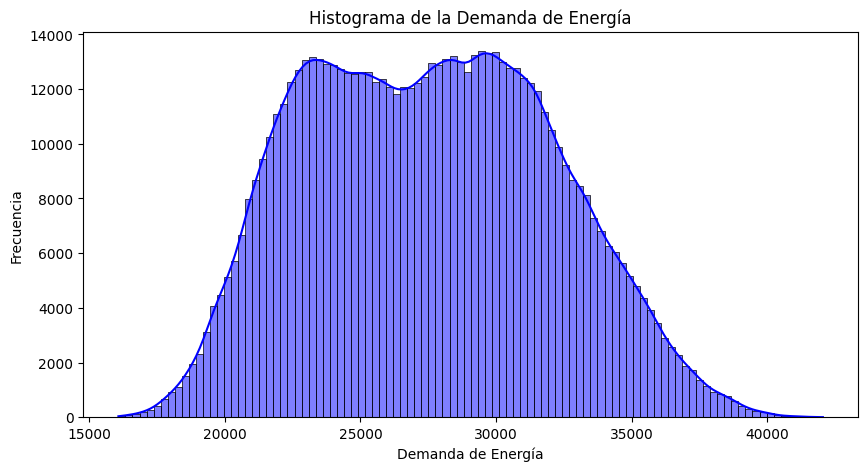

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data['value'], bins=100, kde=True, color="blue")
plt.title("Histograma de la Demanda de Energía")
plt.xlabel("Demanda de Energía")
plt.ylabel("Frecuencia")
plt.show()


**Análisis de Patrones y Estacionalidad**


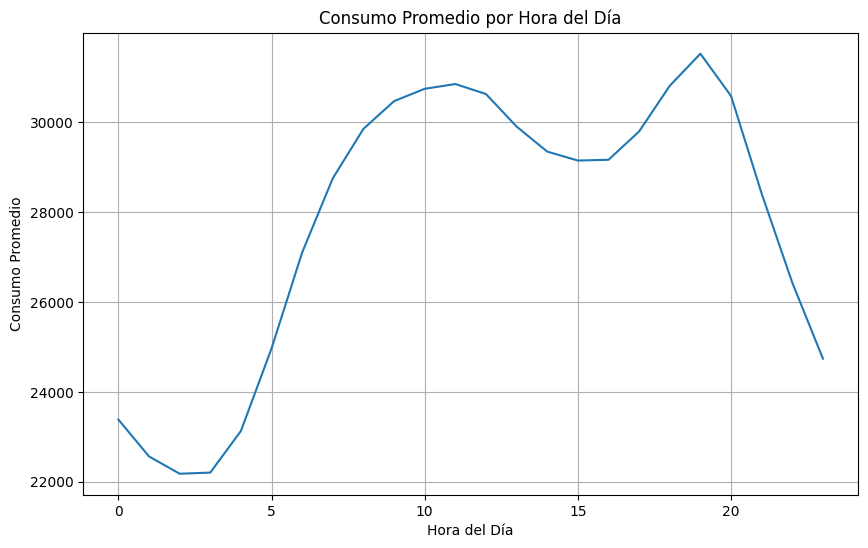

In [ ]:
data['datetime'] = data['datetime'].astype(str)
data['datetime'] = data['datetime'].str.split('+').str[0]
data['datetime'] = pd.to_datetime(data['datetime'])

data.set_index('datetime', inplace=True)

df_hourly = data['value'].resample('H').mean()
df_hourly_by_hour = df_hourly.groupby(df_hourly.index.hour).mean()

plt.figure(figsize=(10, 6))
df_hourly_by_hour.plot()
plt.title('Consumo Promedio por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Consumo Promedio')
plt.grid(True)
plt.show()

<ipython-input-34-52baed056a9f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data['value'].resample('M').mean().plot()


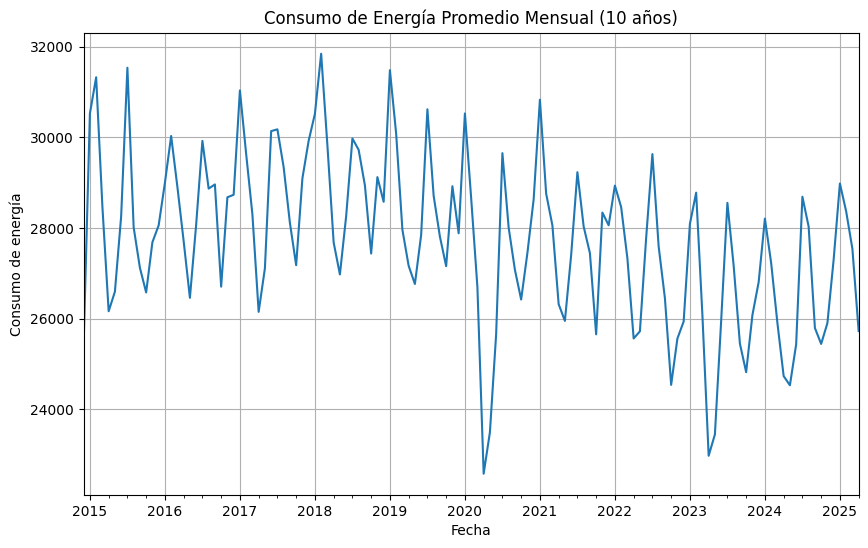

In [ ]:


plt.figure(figsize=(10, 6))
data['value'].resample('M').mean().plot()
plt.title('Consumo de Energía Promedio Mensual (10 años)')
plt.xlabel('Fecha')
plt.ylabel('Consumo de energía')
plt.grid(True)
plt.show()

In [ ]:

df_daily = data['value'].resample('D').mean().to_frame()
df_daily['weekday'] = df_daily.index.weekday

weekly_pattern = df_daily.groupby('weekday')['value'].mean()
values = weekly_pattern.values

weekday_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

offset = 0.03 * max(values)


text_pos_options = []
for i, value in enumerate(values):
    if i == 0:
        delta = values[i+1] - value
    elif i == len(values) - 1:
        delta = value - values[i-1]
    else:
        delta = (values[i+1] - values[i-1]) / 2

    if delta <= 0:
        text_pos_options.append('bottom center')
    else:
        text_pos_options.append('top center')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekday_names,
    y=values,
    mode='lines+markers+text',
    text=[f'{v:.1f}' for v in values],
    textposition=text_pos_options,
    textfont=dict(size=18, color='black', family='Arial Black'),
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=10)
))

fig.update_layout(
    xaxis_title='Día de la Semana',
    yaxis_title='Consumo Promedio (kWh)',
    xaxis=dict(
        tickmode='array',
        tickvals=weekday_names,
        ticktext=weekday_names,
        tickfont=dict(size=24, family='Arial')
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='LightGray',
        zeroline=False,
        tickfont=dict(size=16, family='Arial')
    ),
    plot_bgcolor='white',
    margin=dict(l=70, r=70, t=70, b=70),
    font=dict(size=16)
)

fig.show()


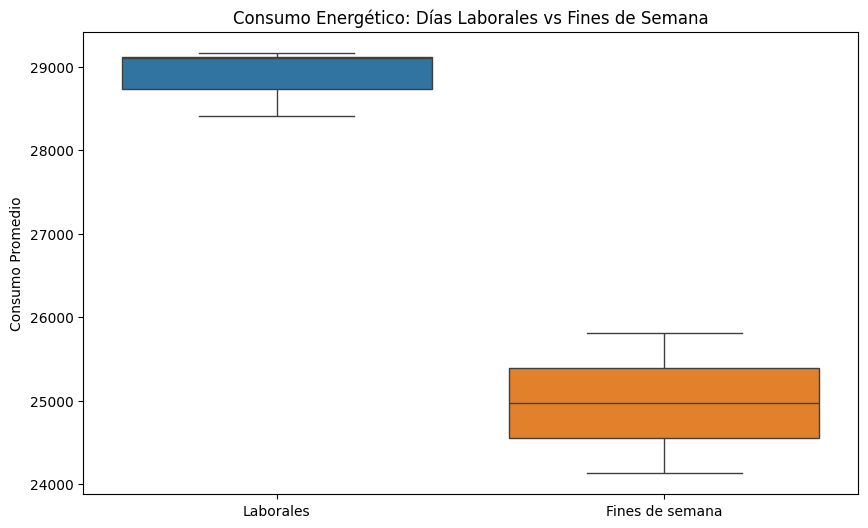

In [ ]:
df_daily = data['value'].resample('D').mean()

df_daily = df_daily.to_frame()
df_daily['weekday'] = df_daily.index.weekday

weekdays = df_daily[df_daily['weekday'] < 5].groupby('weekday')['value'].mean()
weekends = df_daily[df_daily['weekday'] >= 5].groupby('weekday')['value'].mean()

plt.figure(figsize=(10, 6))

data_to_plot = [weekdays.values, weekends.values]
ax = sns.boxplot(data=data_to_plot)

plt.xticks([0, 1], ['Laborales', 'Fines de semana'])

plt.title('Consumo Energético: Días Laborales vs Fines de Semana')
plt.ylabel('Consumo Promedio')
plt.show()

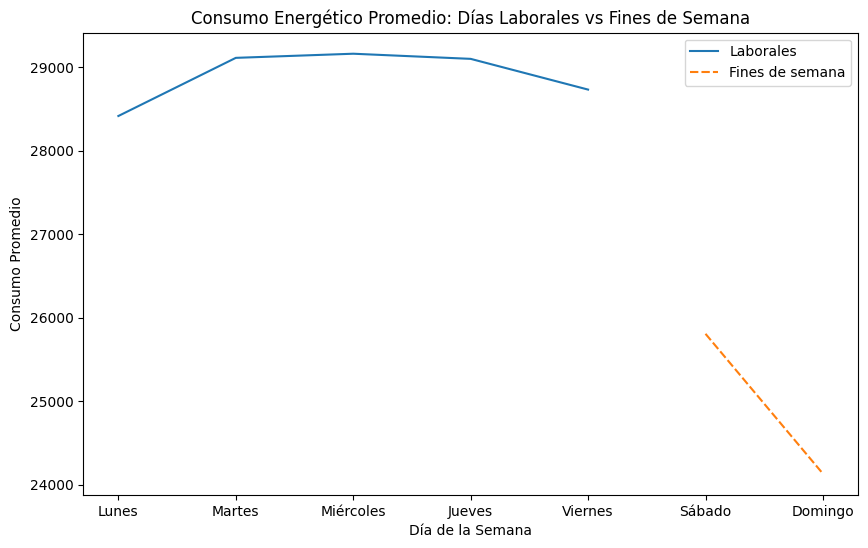

In [ ]:
df_lineplot = pd.DataFrame({
    'Laborales': weekdays,
    'Fines de semana': weekends
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_lineplot)
plt.title('Consumo Energético Promedio: Días Laborales vs Fines de Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Consumo Promedio')
plt.xticks(range(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.show()

<ipython-input-28-2df5e6b6743f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = data['value'].resample('M').mean()


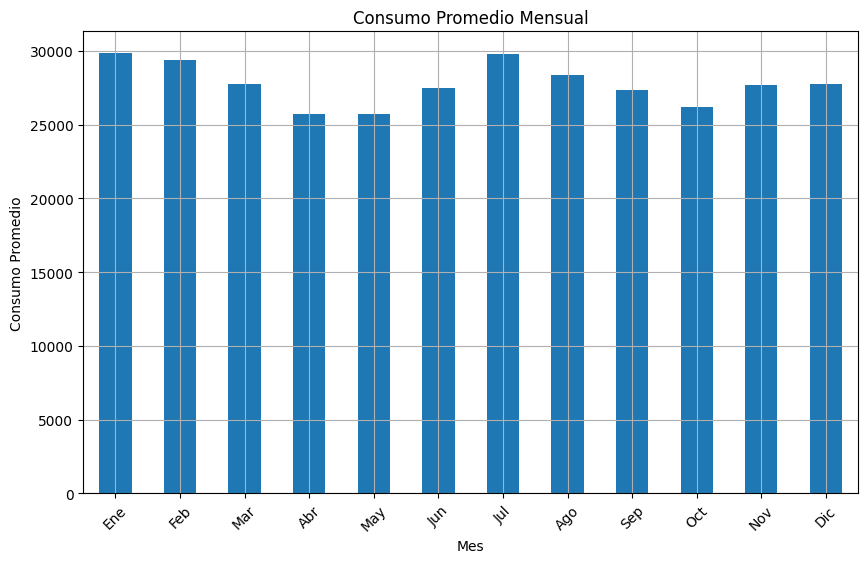

In [ ]:
df_monthly = data['value'].resample('M').mean()

df_monthly = df_monthly.to_frame()
df_monthly['month'] = df_monthly.index.month

df_monthly_mean = df_monthly.groupby('month')['value'].mean()


plt.figure(figsize=(10, 6))
df_monthly_mean.plot(kind='bar')
plt.title('Consumo Promedio Mensual')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.grid(True)
plt.show()

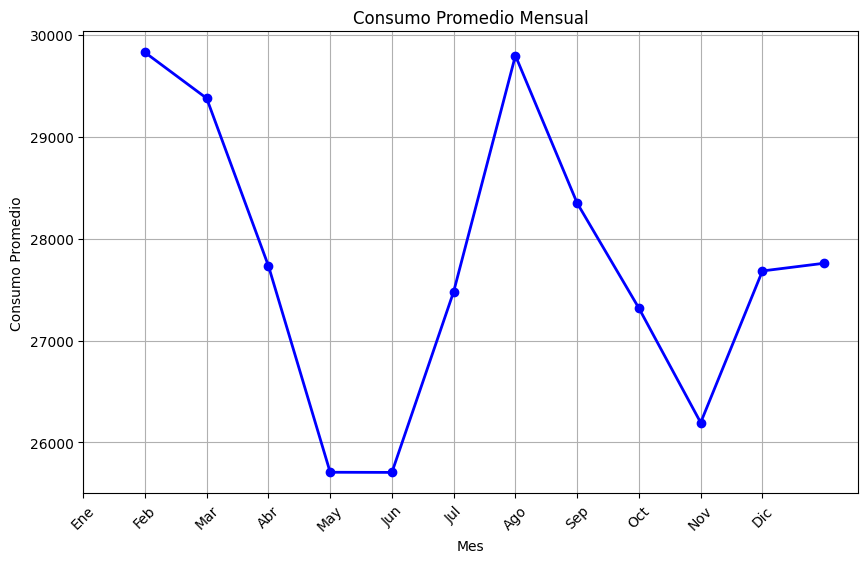

In [ ]:
plt.figure(figsize=(10, 6))
df_monthly_mean.plot(kind='line', marker='o', color='b', linewidth=2)
plt.title('Consumo Promedio Mensual')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.grid(True)
plt.show()


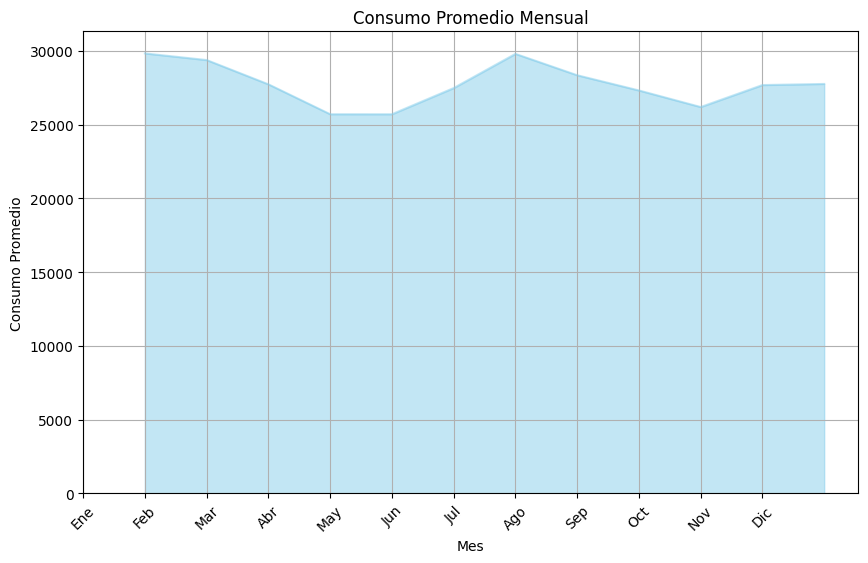

In [ ]:
plt.figure(figsize=(10, 6))
df_monthly_mean.plot(kind='area', color='skyblue', alpha=0.5)
plt.title('Consumo Promedio Mensual')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.grid(True)
plt.show()

<ipython-input-31-b7adf7ea6a69>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = data['value'].resample('A').mean()


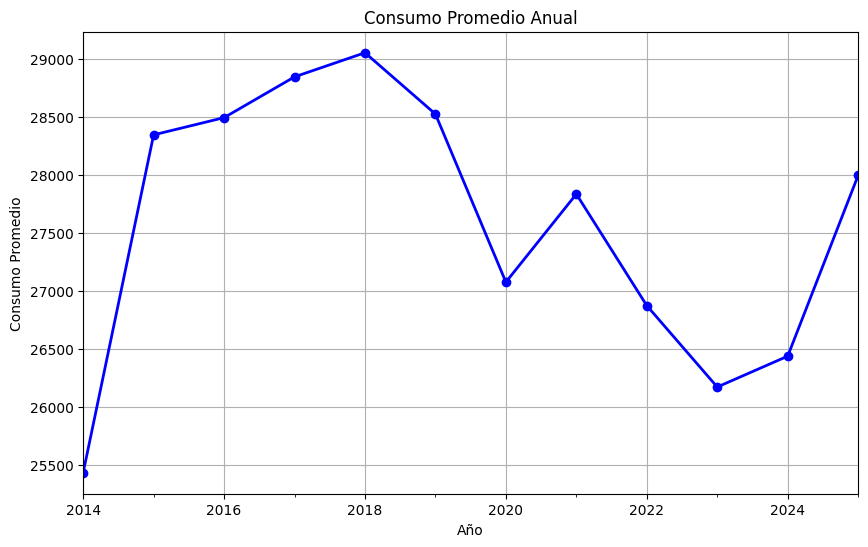

In [ ]:
df_yearly = data['value'].resample('A').mean()


plt.figure(figsize=(10, 6))
df_yearly.plot(kind='line', marker='o', color='b', linewidth=2)
plt.title('Consumo Promedio Anual')
plt.xlabel('Año')
plt.ylabel('Consumo Promedio')
plt.grid(True)
plt.show()


<ipython-input-32-412312c63558>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = data['value'].resample('A').mean()


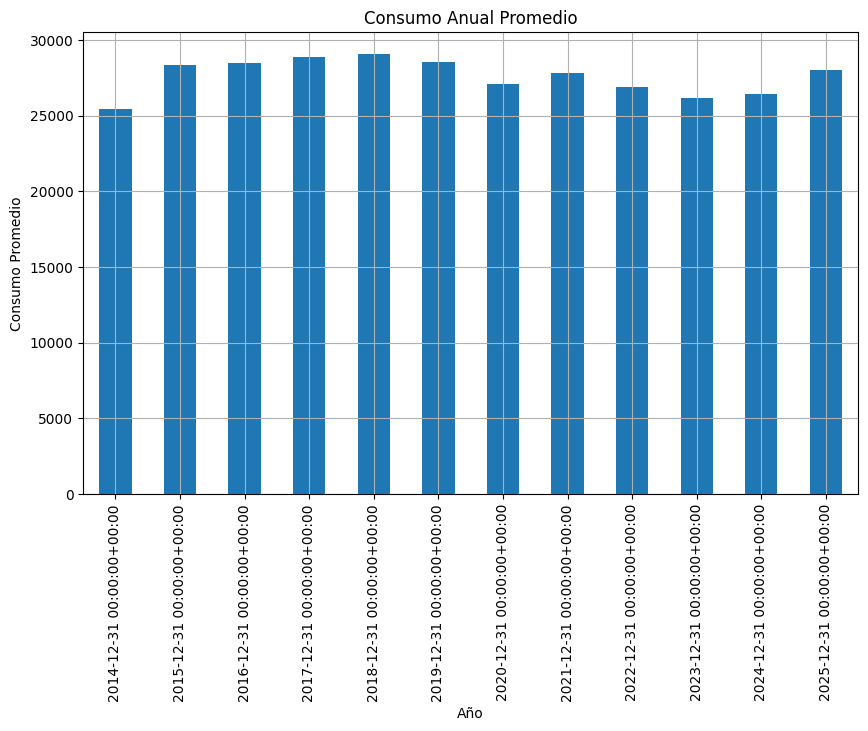

In [ ]:
df_yearly = data['value'].resample('A').mean()

plt.figure(figsize=(10, 6))
df_yearly.plot(kind='bar')
plt.title('Consumo Anual Promedio')
plt.xlabel('Año')
plt.ylabel('Consumo Promedio')
plt.grid(True)
plt.show()


In [ ]:
percentile_95 = data['value'].quantile(0.95)

picos = data[data['value'] > percentile_95]

print(picos)


                           value
datetime                        
2015-01-07 08:20:00+00:00  35272
2015-01-07 08:30:00+00:00  35332
2015-01-07 08:40:00+00:00  35784
2015-01-07 08:50:00+00:00  35905
2015-01-07 09:00:00+00:00  36208
...                          ...
2025-03-25 20:00:00+00:00  35397
2025-03-25 20:05:00+00:00  35348
2025-03-25 20:10:00+00:00  35249
2025-03-25 20:15:00+00:00  35219
2025-03-25 20:20:00+00:00  35137

[34620 rows x 1 columns]


**Descomposición de la Serie Temporal**

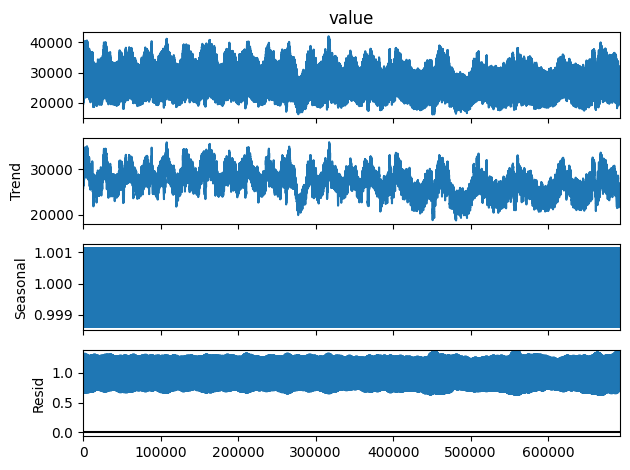

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['value'], model='multiplicative', period=365)

result.plot()
plt.show()


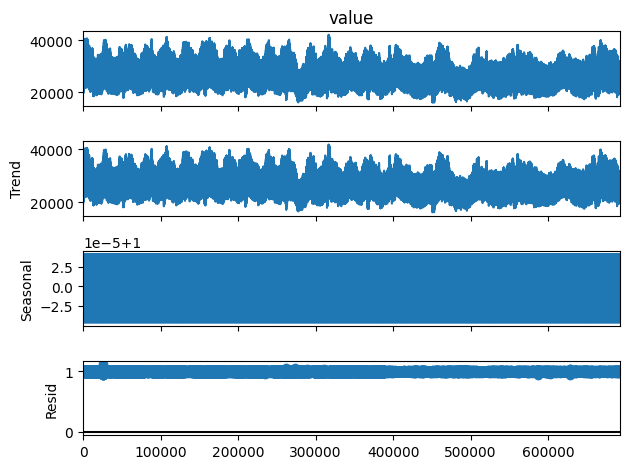

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['value'], model='multiplicative', period=7)

result.plot()
plt.show()

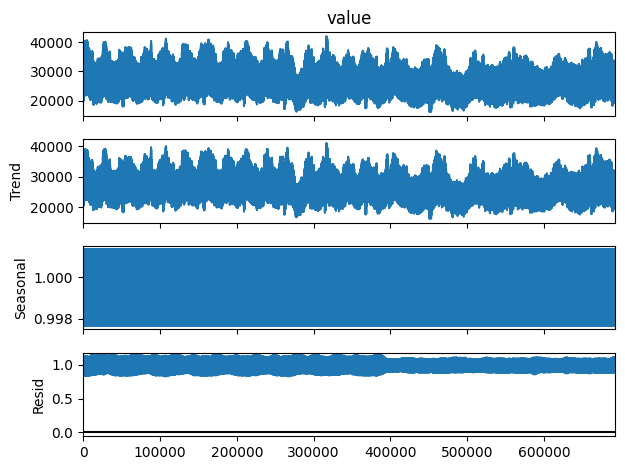

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['value'], model='multiplicative', period=30)

result.plot()
plt.show()

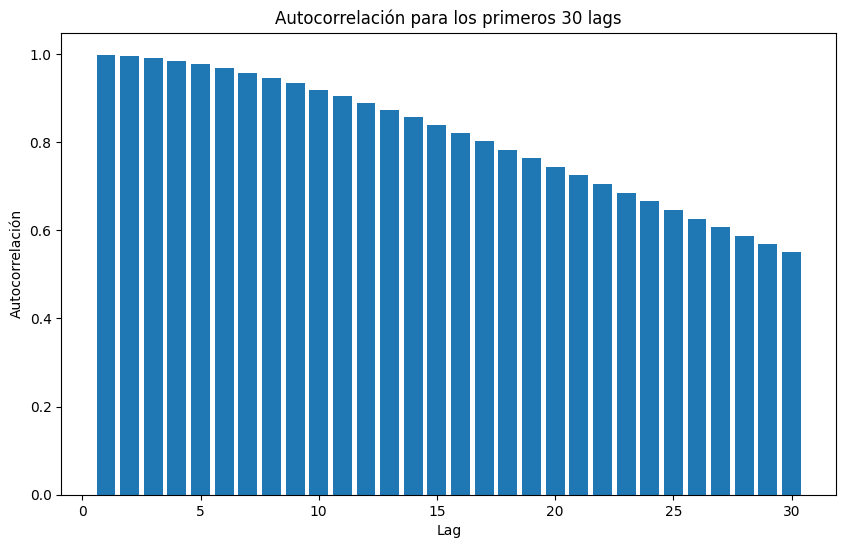

In [ ]:
import numpy as np

lags = 30
autocorr_values = [data['value'].autocorr(lag=i) for i in range(1, lags + 1)]

plt.figure(figsize=(10, 6))
plt.bar(range(1, lags + 1), autocorr_values)
plt.title('Autocorrelación para los primeros 30 lags')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.show()


<ipython-input-96-2cd850922ec2>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plot_acf(data['value'].resample('M').mean(), lags=30)  # Limitar a 30 lags


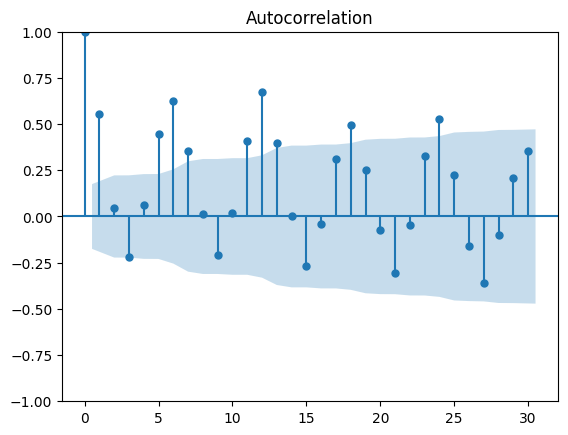

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['value'].resample('M').mean(), lags=30)
plt.show()


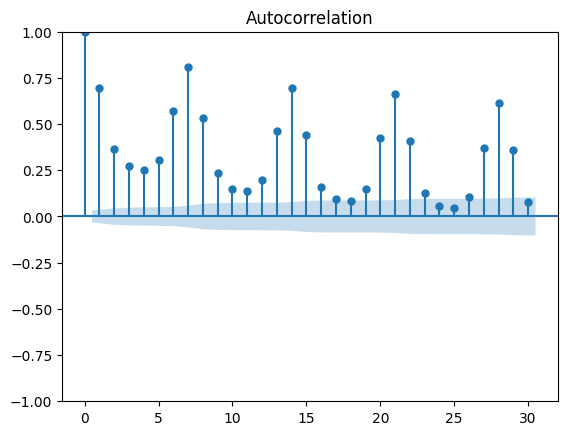

In [ ]:
plot_acf(data['value'].resample('D').mean(), lags=30)
plt.show()


In [ ]:
mape = (comparison['y'] - comparison['yhat']).abs().mean() / comparison['y'].mean() * 100
print(f'MAPE (Error porcentual absoluto medio): {mape:.2f}%')


MAPE (Error porcentual absoluto medio): 4.36%


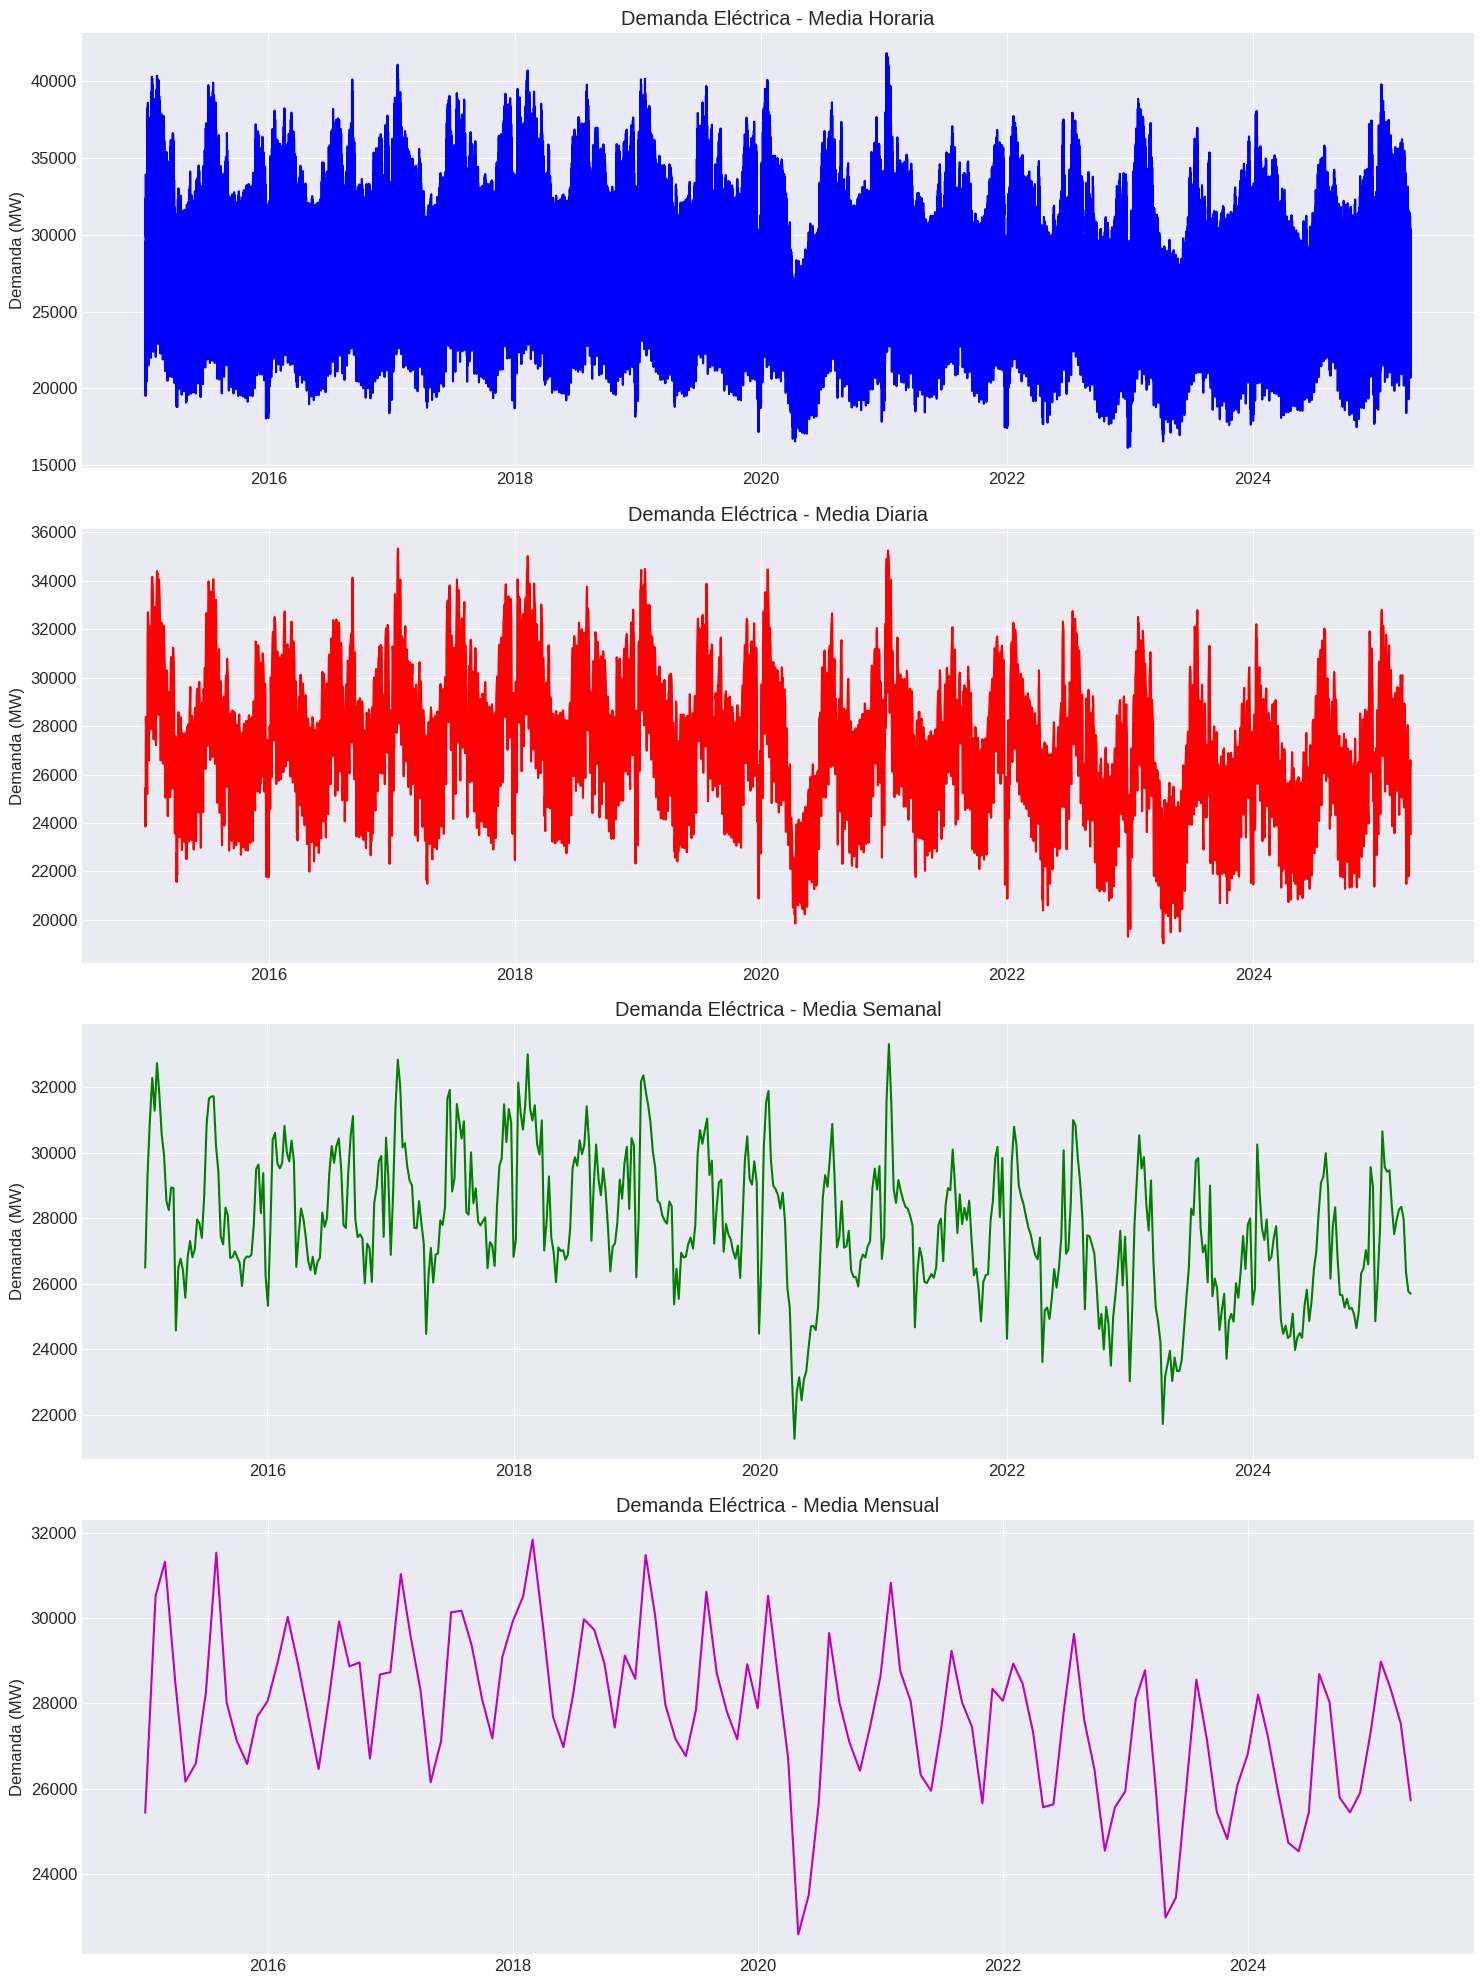

In [ ]:
df_hora = df.resample('H').mean()
df_dia = df.resample('D').mean()
df_semana = df.resample('W').mean()
df_mes = df.resample('M').mean()

fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=False)

axes[0].plot(df_hora.index, df_hora['demanda_mw'], 'b-')
axes[0].set_title('Demanda Eléctrica - Media Horaria')
axes[0].set_ylabel('Demanda (MW)')
axes[0].grid(True)

axes[1].plot(df_dia.index, df_dia['demanda_mw'], 'r-')
axes[1].set_title('Demanda Eléctrica - Media Diaria')
axes[1].set_ylabel('Demanda (MW)')
axes[1].grid(True)

axes[2].plot(df_semana.index, df_semana['demanda_mw'], 'g-')
axes[2].set_title('Demanda Eléctrica - Media Semanal')
axes[2].set_ylabel('Demanda (MW)')
axes[2].grid(True)

axes[3].plot(df_mes.index, df_mes['demanda_mw'], 'm-')
axes[3].set_title('Demanda Eléctrica - Media Mensual')
axes[3].set_ylabel('Demanda (MW)')
axes[3].grid(True)

plt.tight_layout()
plt.show()


=== ANÁLISIS COMPLETO DE DEMANDA ELÉCTRICA ===

Archivo cargado correctamente: 692585 filas, 4 columnas
Datos originales: 692585 registros
Datos horarios: 90114 registros
Datos diarios: 3756 registros

Analizando patrones temporales...


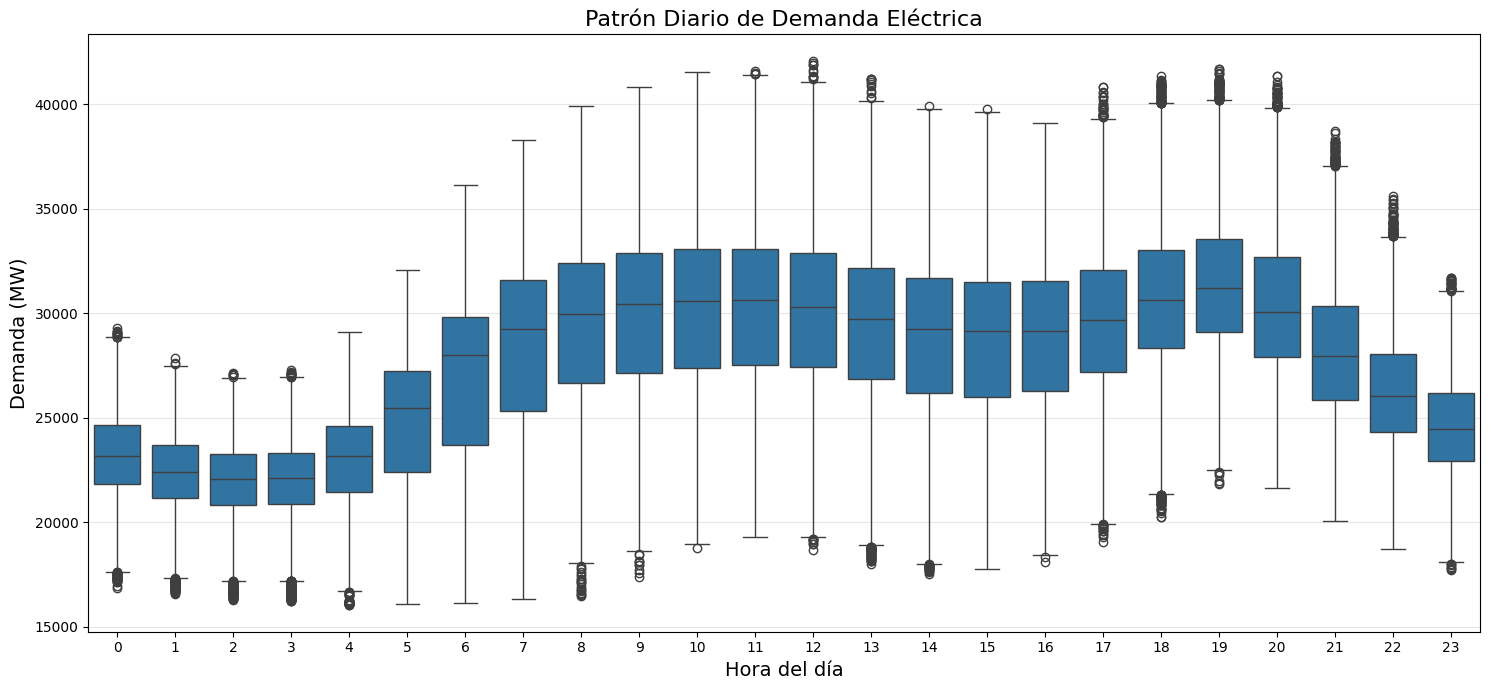

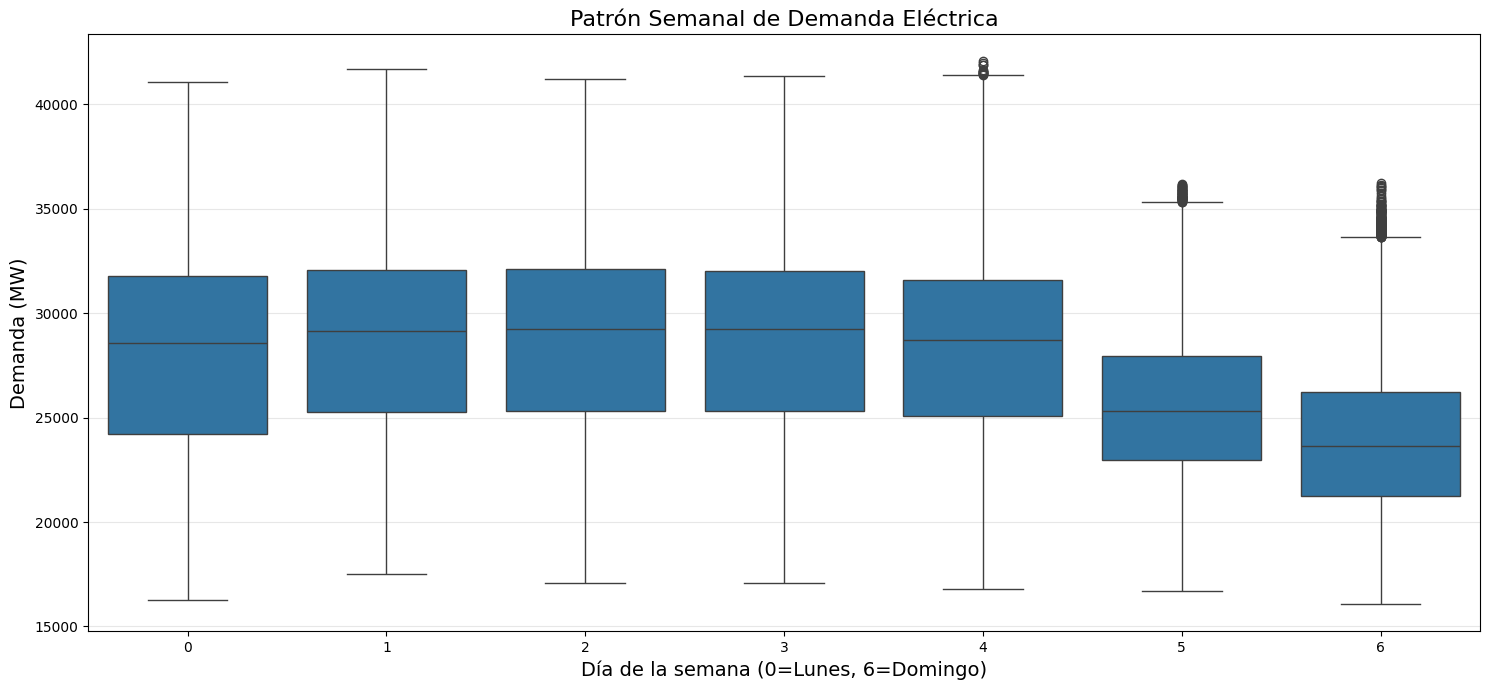

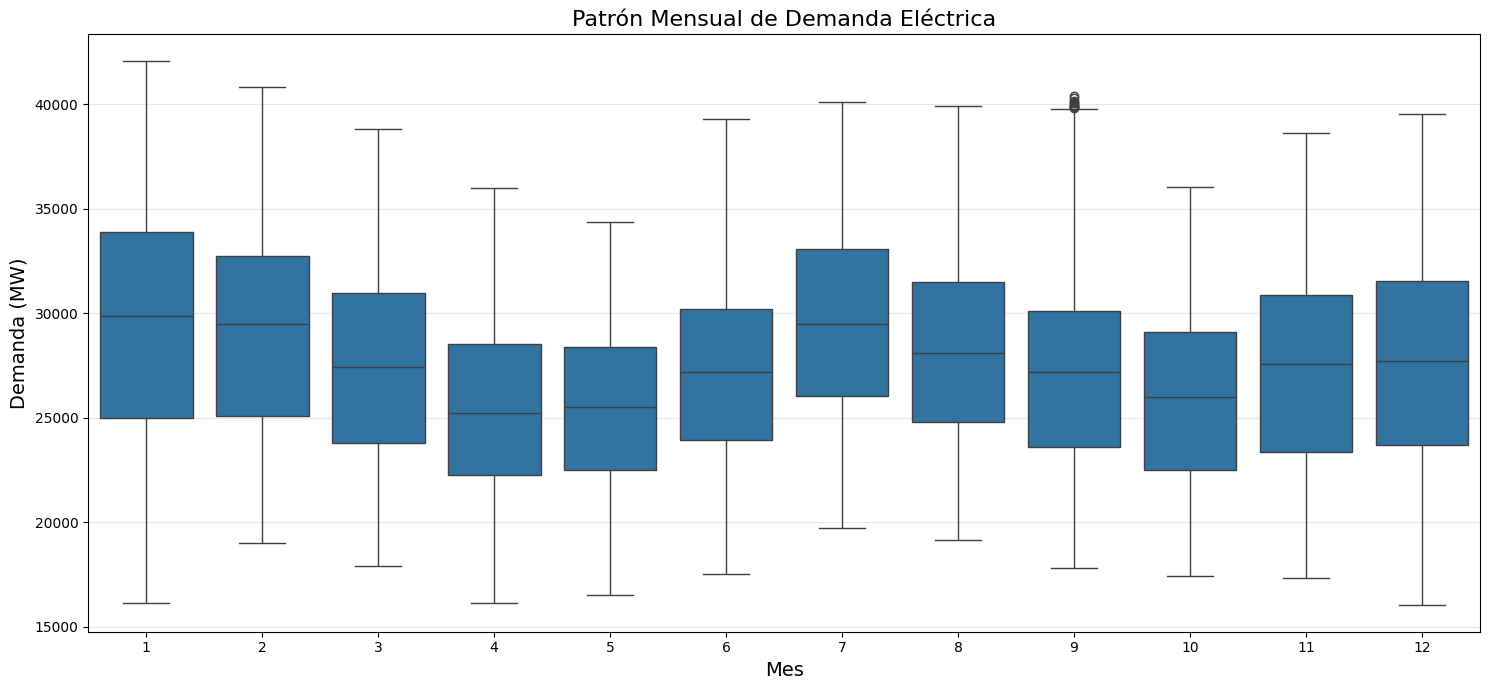

Realizando descomposición estacional diaria...


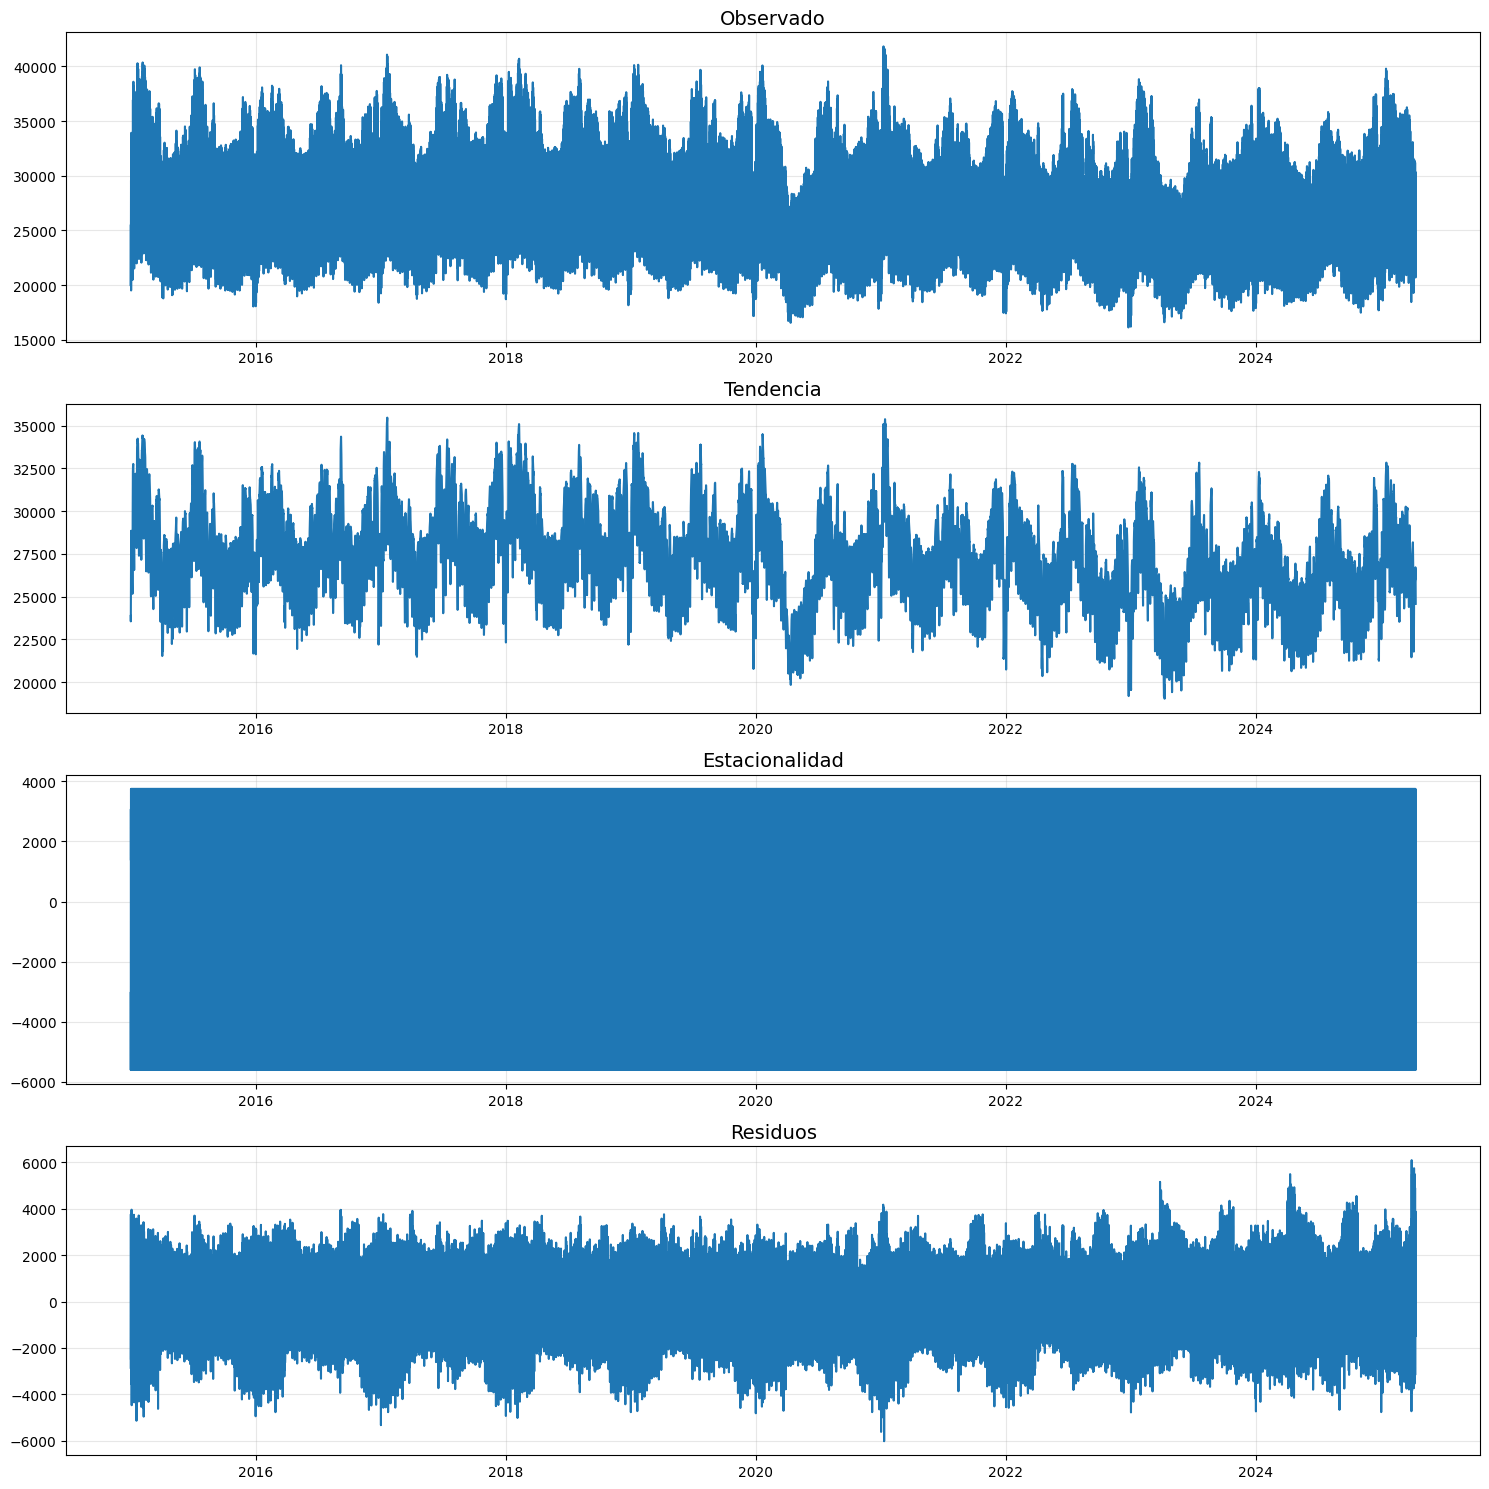


Realizando descomposición estacional semanal...
Usando muestra de 50000 registros para descomposición semanal


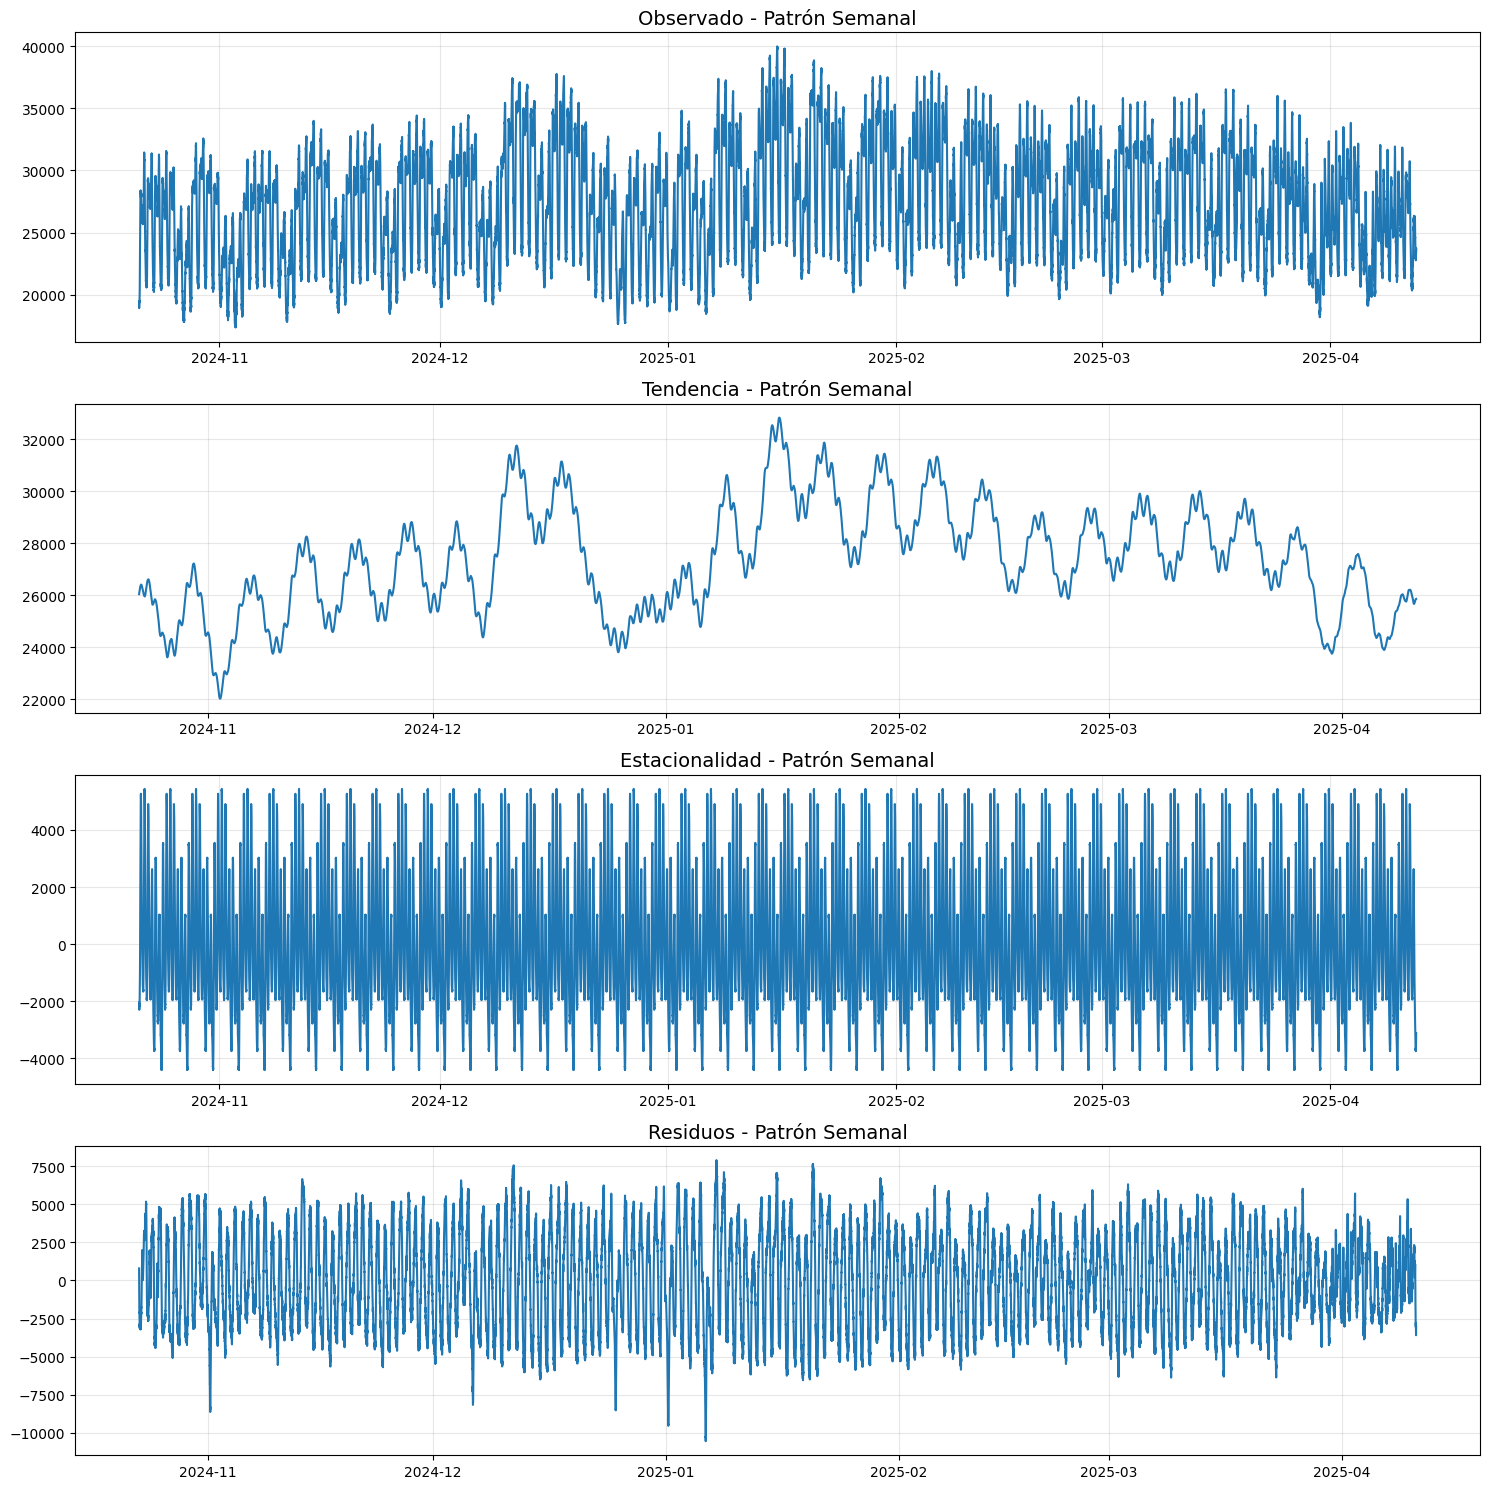


Analizando funciones de autocorrelación...


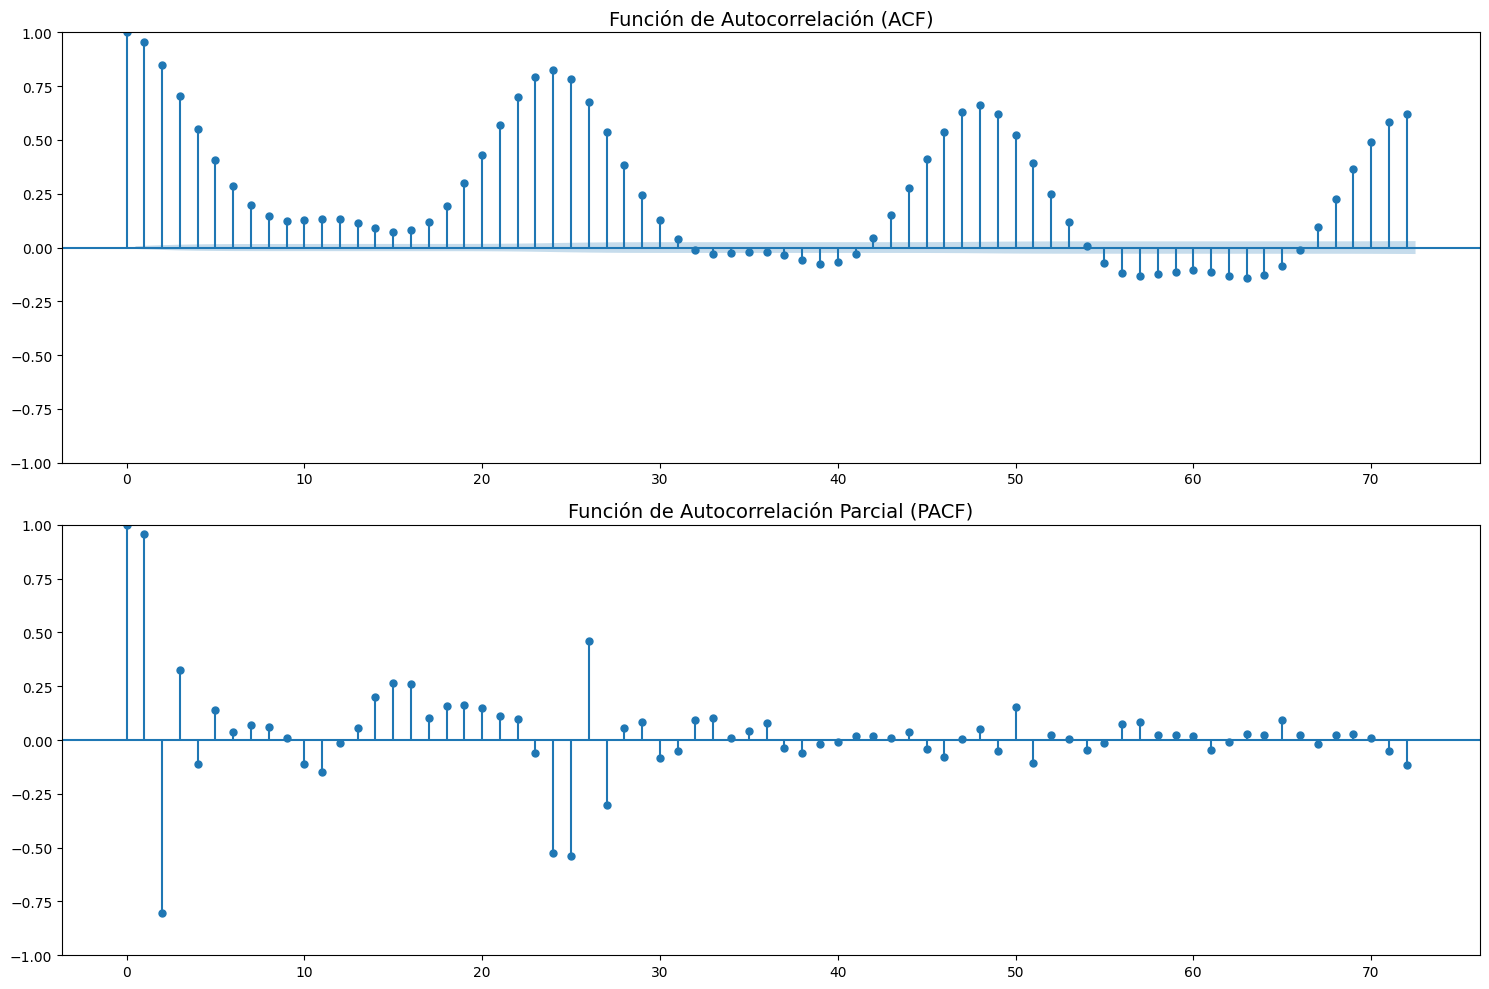


Realizando test de estacionariedad...


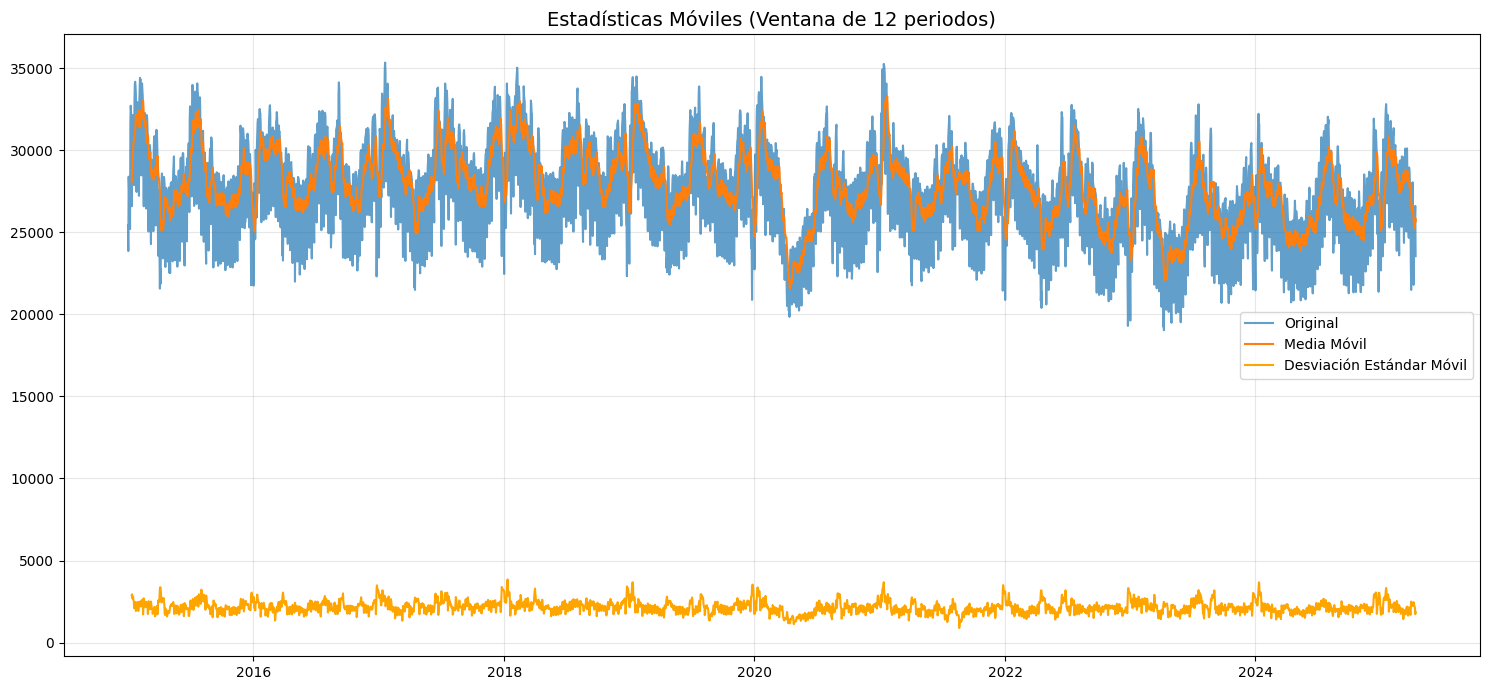


Calculando desviación estándar móvil con agregación D...


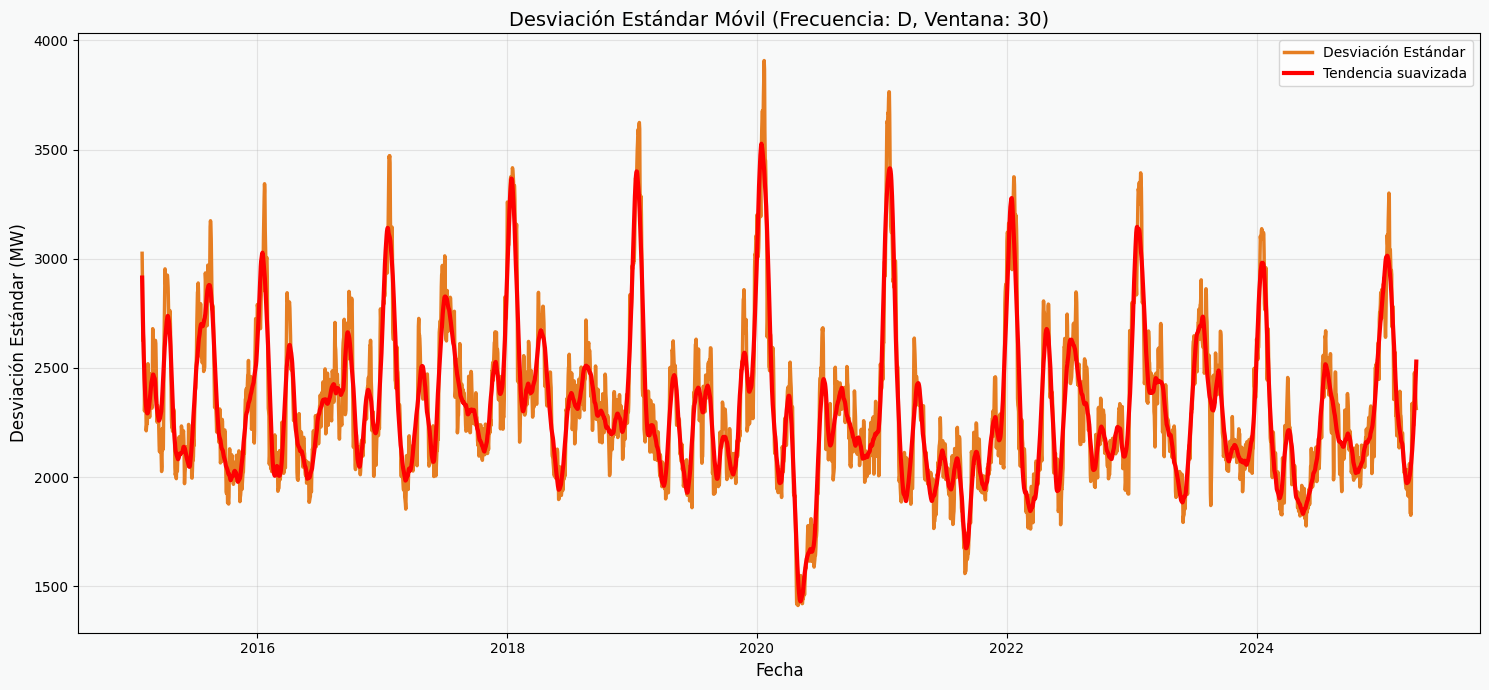


Calculando desviación estándar móvil con agregación W...


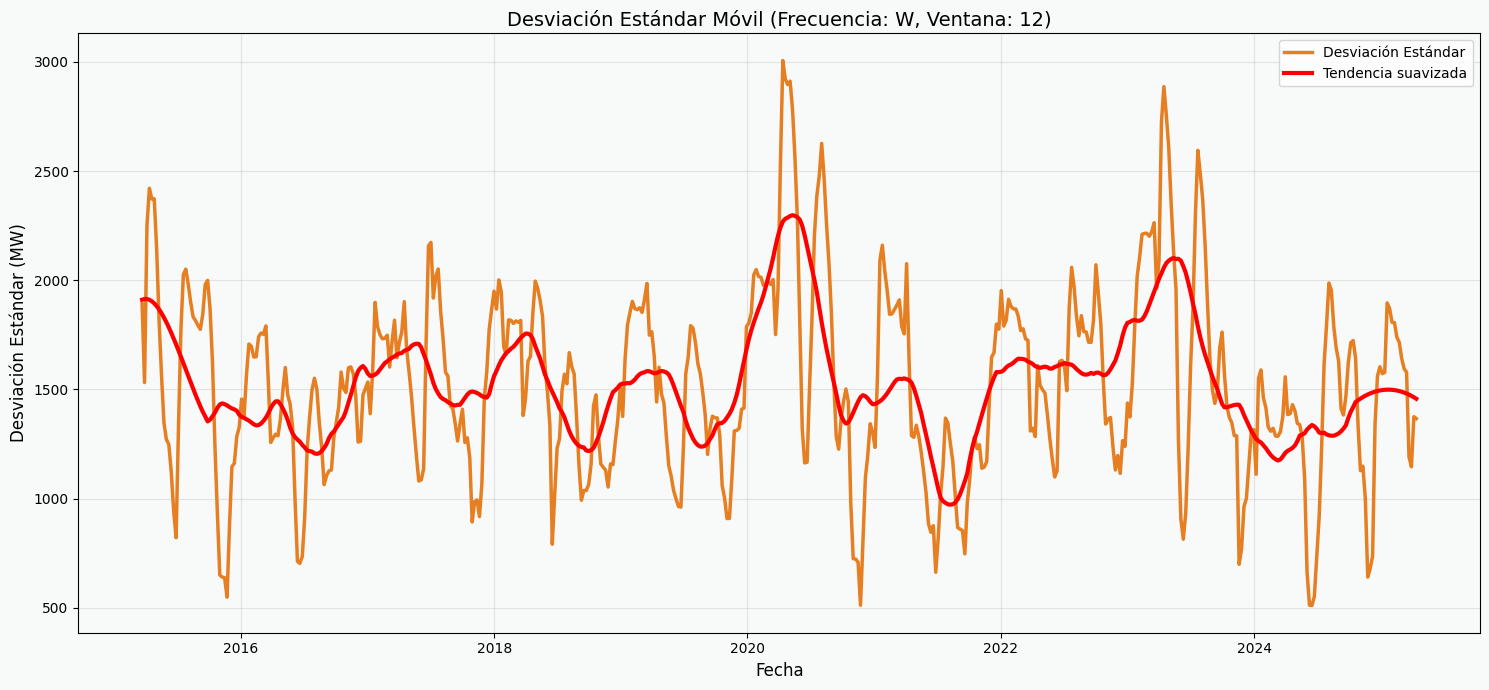


Calculando desviación estándar móvil con agregación M...


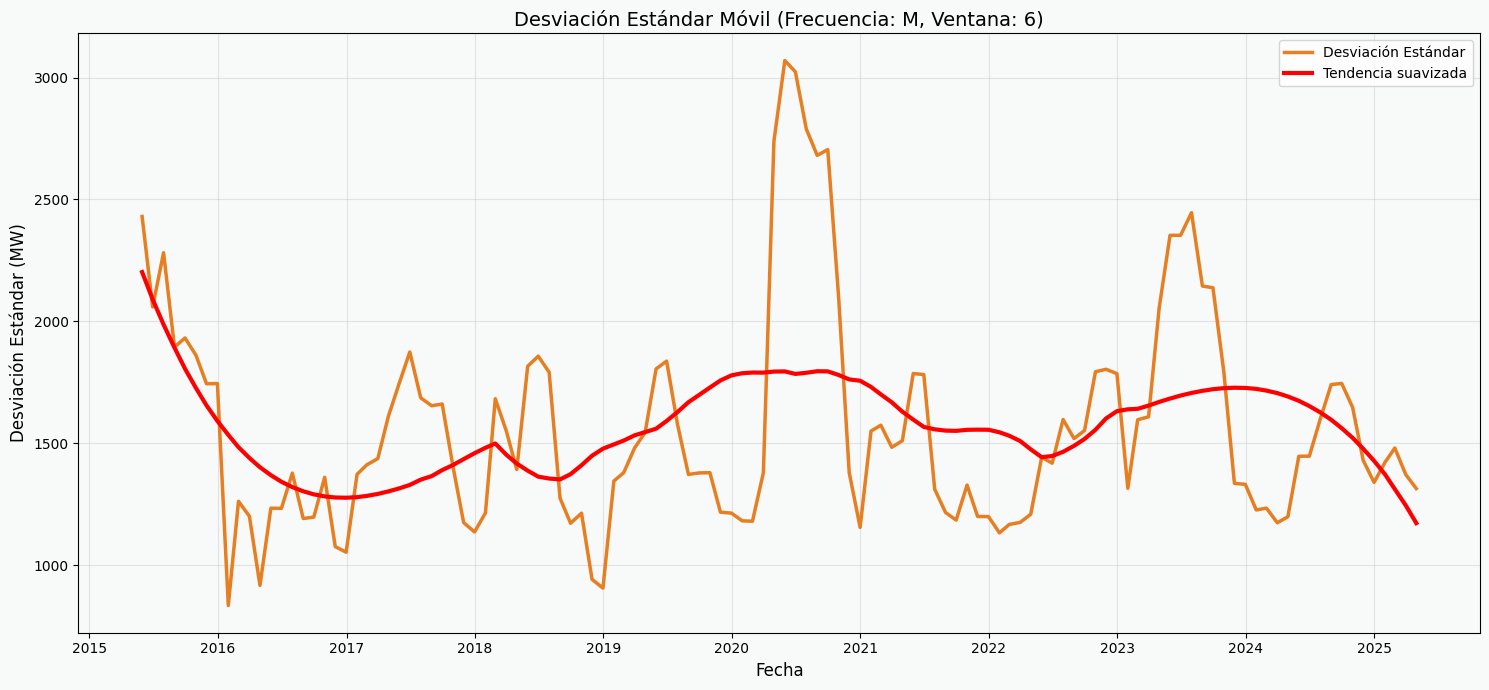

Resultados de la Prueba Dickey-Fuller Aumentada:
Estadístico ADF: -6.716239858382118
p-value: 3.576093609027451e-09
# de Lags: 30
# de Observaciones: 3725
Conclusión: La serie es estacionaria (rechazamos la hipótesis nula)

=== ANÁLISIS COMPLETO FINALIZADO ===


In [ ]:


def cargar_datos(ruta_archivo):
    try:
        df = pd.read_excel(ruta_archivo)
        print(f"Archivo cargado correctamente: {df.shape[0]} filas, {df.shape[1]} columnas")
        return df
    except FileNotFoundError:
        print(f"¡Error! No se encontró el archivo: {ruta_archivo}")
        print("Revisa la ruta del archivo y asegúrate de que está en el directorio correcto.")
        print("Creando datos simulados para demostración...")

        fechas = pd.date_range(start='2015-01-01', end='2025-03-25 20:20:00', freq='10T')

        np.random.seed(42)
        n = len(fechas)
        base = 25000

        hora_dia = np.sin(2 * np.pi * fechas.hour / 24) * 5000
        dia_semana = -np.sin(2 * np.pi * fechas.dayofweek / 7) * 2000
        mes_anual = np.sin(2 * np.pi * fechas.month / 12) * 3000


        tendencia = np.linspace(0, 5000, n) * (np.sin(np.linspace(0, 8*np.pi, n)) * 0.1 + 0.9)


        ruido = np.random.normal(0, 1000, n)


        demanda = base + hora_dia + dia_semana + mes_anual + tendencia + ruido

        df_simulado = pd.DataFrame({
            'datetime_utc': fechas,
            'value': demanda,
            'geo_id': [8741] * n,
            'geo_name': ['Peninsula'] * n
        })

        return df_simulado

def preparar_datos(df):
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
    df['datetime_utc'] = df['datetime_utc'].dt.tz_localize(None)

    df = df.set_index('datetime_utc')

    if 'geo_id' in df.columns and 'geo_name' in df.columns:
        df = df.drop(columns=['geo_id', 'geo_name'])

    if 'value' in df.columns:
        df = df.rename(columns={'value': 'demanda_mw'})

    df_hora = df['demanda_mw'].resample('H').mean().to_frame()
    df_dia = df['demanda_mw'].resample('D').mean().to_frame()

    print(f"Datos originales: {df.shape[0]} registros")
    print(f"Datos horarios: {df_hora.shape[0]} registros")
    print(f"Datos diarios: {df_dia.shape[0]} registros")

    return df, df_hora, df_dia

def crear_caracteristicas_tiempo(df):
    df['hora'] = df.index.hour
    df['dia_semana'] = df.index.dayofweek
    df['dia_mes'] = df.index.day
    df['mes'] = df.index.month
    df['año'] = df.index.year
    df['es_finde'] = df['dia_semana'].isin([5, 6]).astype(int)
    return df

def analizar_patrones(df):
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='hora', y='demanda_mw', data=df.reset_index())
    plt.title('Patrón Diario de Demanda Eléctrica', fontsize=16)
    plt.xlabel('Hora del día', fontsize=14)
    plt.ylabel('Demanda (MW)', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 7))
    sns.boxplot(x='dia_semana', y='demanda_mw', data=df.reset_index())
    plt.title('Patrón Semanal de Demanda Eléctrica', fontsize=16)
    plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)', fontsize=14)
    plt.ylabel('Demanda (MW)', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 7))
    sns.boxplot(x='mes', y='demanda_mw', data=df.reset_index())
    plt.title('Patrón Mensual de Demanda Eléctrica', fontsize=16)
    plt.xlabel('Mes', fontsize=14)
    plt.ylabel('Demanda (MW)', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def descomponer_series(df_hora, df):
    print("Realizando descomposición estacional diaria...")
    descomposicion = seasonal_decompose(df_hora['demanda_mw'], model='additive', period=24)

    plt.figure(figsize=(15, 15))
    plt.subplot(411)
    plt.plot(descomposicion.observed)
    plt.title('Observado', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.subplot(412)
    plt.plot(descomposicion.trend)
    plt.title('Tendencia', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.subplot(413)
    plt.plot(descomposicion.seasonal)
    plt.title('Estacionalidad', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.subplot(414)
    plt.plot(descomposicion.resid)
    plt.title('Residuos', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nRealizando descomposición estacional semanal...")
    try:
        if len(df) > 50000:
            muestra = df.iloc[-50000:].copy()
            print(f"Usando muestra de {len(muestra)} registros para descomposición semanal")
            descomposicion_semanal = seasonal_decompose(muestra['demanda_mw'], model='additive', period=1008)
        else:
            descomposicion_semanal = seasonal_decompose(df['demanda_mw'], model='additive', period=1008)

        plt.figure(figsize=(15, 15))
        plt.subplot(411)
        plt.plot(descomposicion_semanal.observed)
        plt.title('Observado - Patrón Semanal', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.subplot(412)
        plt.plot(descomposicion_semanal.trend)
        plt.title('Tendencia - Patrón Semanal', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.subplot(413)
        plt.plot(descomposicion_semanal.seasonal)
        plt.title('Estacionalidad - Patrón Semanal', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.subplot(414)
        plt.plot(descomposicion_semanal.resid)
        plt.title('Residuos - Patrón Semanal', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error en descomposición semanal: {e}")
        print("Intenta con una muestra más pequeña o ajusta el parámetro de periodo.")

def analizar_correlacion(df_hora):
    print("\nAnalizando funciones de autocorrelación...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    plot_acf(df_hora['demanda_mw'], lags=72, ax=ax1)
    ax1.set_title('Función de Autocorrelación (ACF)', fontsize=14)
    plot_pacf(df_hora['demanda_mw'], lags=72, ax=ax2)
    ax2.set_title('Función de Autocorrelación Parcial (PACF)', fontsize=14)
    plt.tight_layout()
    plt.show()

def desviacion_estandar_suavizada(df_original, frecuencia='W', ventana=12):

    print(f"\nCalculando desviación estándar móvil con agregación {frecuencia}...")
    df_resampled = df_original['demanda_mw'].resample(frecuencia).mean()

    std_movil = df_resampled.rolling(window=ventana).std()


    plt.figure(figsize=(15, 7))
    plt.title(f'Desviación Estándar Móvil (Frecuencia: {frecuencia}, Ventana: {ventana})', fontsize=14)
    plt.plot(std_movil, label=f'Desviación Estándar',
             linewidth=2.5, color='#E67E22')


    if len(std_movil) > 50:
        try:
            std_smooth = savgol_filter(std_movil.dropna(),
                                      min(51, len(std_movil.dropna()) - (len(std_movil.dropna()) % 2 + 1)),
                                      3)
            plt.plot(std_movil.dropna().index, std_smooth, 'r-',
                    linewidth=3, label='Tendencia suavizada')
        except Exception as e:
            print(f"No se pudo aplicar el filtro de suavizado: {e}")

    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Desviación Estándar (MW)', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.gcf().set_facecolor('#F8F9F9')
    plt.gca().set_facecolor('#F8F9F9')
    plt.tight_layout()
    plt.show()

    return std_movil

def test_estacionariedad(serie, window=12):
    print("\nRealizando test de estacionariedad...")
    media_movil = serie.rolling(window=window).mean()
    std_movil = serie.rolling(window=window).std()

    plt.figure(figsize=(15, 7))
    plt.title(f'Estadísticas Móviles (Ventana de {window} periodos)', fontsize=14)
    plt.plot(serie, label='Original', alpha=0.7)
    plt.plot(media_movil, label='Media Móvil', linewidth=1.5)
    plt.plot(std_movil, label='Desviación Estándar Móvil', linewidth=1.5, color='orange')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    std_diaria = desviacion_estandar_suavizada(serie.to_frame(), frecuencia='D', ventana=30)
    std_semanal = desviacion_estandar_suavizada(serie.to_frame(), frecuencia='W', ventana=12)
    std_mensual = desviacion_estandar_suavizada(serie.to_frame(), frecuencia='M', ventana=6)

    print('Resultados de la Prueba Dickey-Fuller Aumentada:')
    resultado = adfuller(serie.dropna())
    etiquetas = ['Estadístico ADF', 'p-value', '# de Lags', '# de Observaciones']

    for etiqueta, valor in zip(etiquetas, resultado[:4]):
        print(f'{etiqueta}: {valor}')

    if resultado[1] <= 0.05:
        print("Conclusión: La serie es estacionaria (rechazamos la hipótesis nula)")
    else:
        print("Conclusión: La serie no es estacionaria (no rechazamos la hipótesis nula)")

def main():
    print("=== ANÁLISIS COMPLETO DE DEMANDA ELÉCTRICA ===\n")

    archivo = 'Unificado_def_2015_2025.xlsx'
    df_raw = cargar_datos(archivo)

    df, df_hora, df_dia = preparar_datos(df_raw)

    df = crear_caracteristicas_tiempo(df)

    print("\nAnalizando patrones temporales...")
    analizar_patrones(df)

    descomponer_series(df_hora, df)

    analizar_correlacion(df_hora)

    test_estacionariedad(df_dia['demanda_mw'], window=12)

    print("\n=== ANÁLISIS COMPLETO FINALIZADO ===")

    return df, df_hora, df_dia


if __name__ == "__main__":
    df, df_hora, df_dia = main()



==== Test de Dickey-Fuller para serie diaria ====
                   Métrica         Valor
0          Estadístico ADF      -6.71624
1                  p-valor  0.0000000036
2           Número de lags          30.0
3  Número de observaciones        3725.0
4       Valor crítico (1%)     -3.432107
5       Valor crítico (5%)     -2.862316
6      Valor crítico (10%)     -2.567183

Conclusión:
✅ La serie ES ESTACIONARIA (rechazamos H₀)


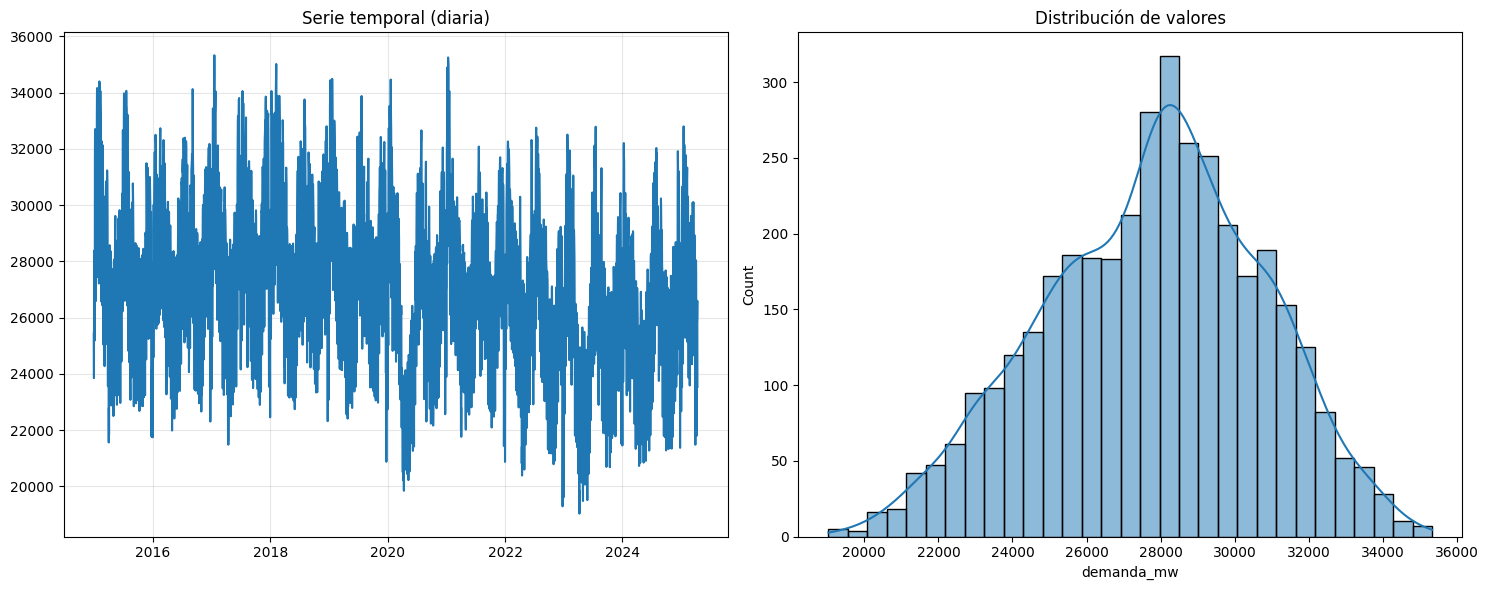


==== Test de Dickey-Fuller para serie semanal ====
                   Métrica         Valor
0          Estadístico ADF     -2.568595
1                  p-valor  0.0996634000
2           Número de lags          19.0
3  Número de observaciones         517.0
4       Valor crítico (1%)     -3.443062
5       Valor crítico (5%)     -2.867147
6      Valor crítico (10%)     -2.569756

Conclusión:
❌ La serie NO ES ESTACIONARIA (no rechazamos H₀)


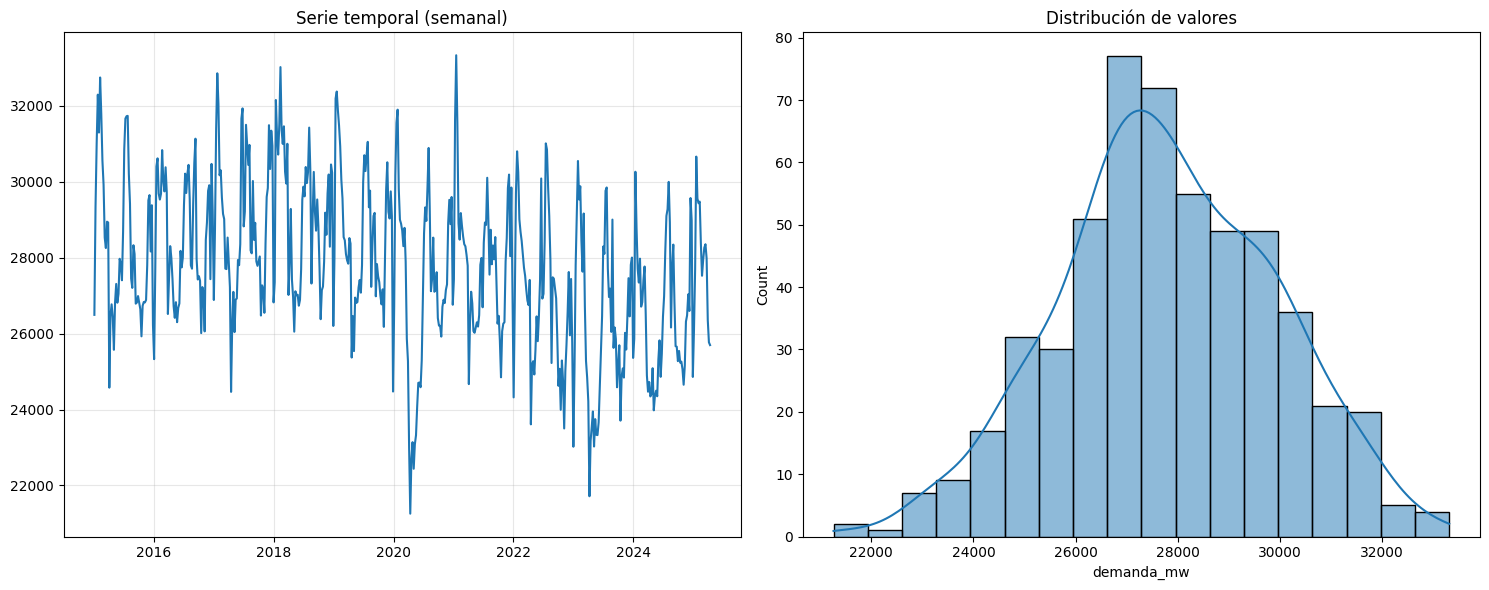


==== Análisis con diferenciación (para remover tendencia) ====

==== Test de Dickey-Fuller para serie diaria diferenciada ====
                   Métrica         Valor
0          Estadístico ADF    -14.381854
1                  p-valor  0.0000000000
2           Número de lags          27.0
3  Número de observaciones        3727.0
4       Valor crítico (1%)     -3.432106
5       Valor crítico (5%)     -2.862316
6      Valor crítico (10%)     -2.567183

Conclusión:
✅ La serie ES ESTACIONARIA (rechazamos H₀)


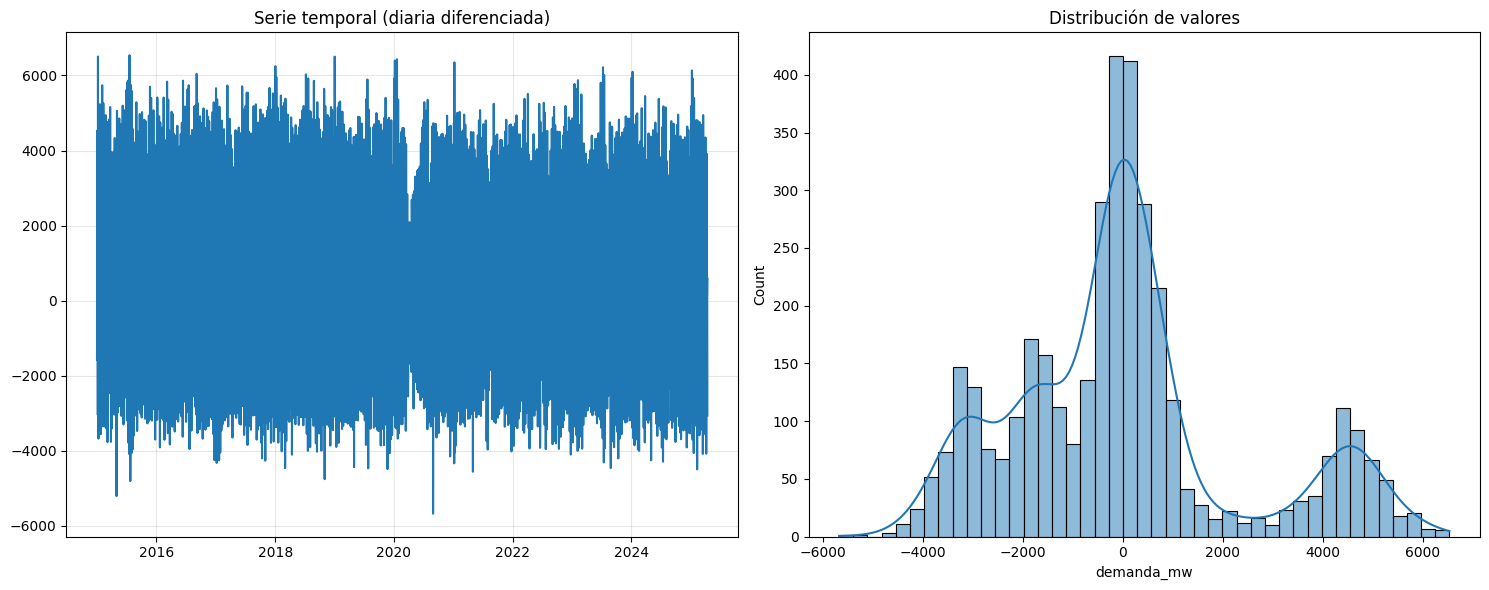

In [ ]:

df_hora = df['demanda_mw'].resample('H').mean()
df_dia = df['demanda_mw'].resample('D').mean()
df_semana = df['demanda_mw'].resample('W').mean()

def realizar_test_adf(serie, nombre):
    """Realiza el test de Dickey-Fuller y muestra resultados detallados"""
    print(f"\n==== Test de Dickey-Fuller para serie {nombre} ====")

    resultado = adfuller(serie.dropna())

    tabla = pd.DataFrame({
        'Métrica': ['Estadístico ADF', 'p-valor', 'Número de lags', 'Número de observaciones',
                    'Valor crítico (1%)', 'Valor crítico (5%)', 'Valor crítico (10%)'],
        'Valor': [resultado[0], resultado[1], resultado[2], resultado[3]] +
                 list(resultado[4].values())
    })

    tabla.loc[1, 'Valor'] = f"{tabla.loc[1, 'Valor']:.10f}"

    print(tabla)

    es_estacionaria = resultado[1] < 0.05
    print("\nConclusión:")
    if es_estacionaria:
        print("✅ La serie ES ESTACIONARIA (rechazamos H₀)")
    else:
        print("❌ La serie NO ES ESTACIONARIA (no rechazamos H₀)")

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(serie)
    plt.title(f'Serie temporal ({nombre})')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.histplot(serie, kde=True)
    plt.title('Distribución de valores')
    plt.tight_layout()
    plt.show()

    return resultado, es_estacionaria

resultado_dia, es_estacionaria_dia = realizar_test_adf(df_dia, "diaria")
resultado_semana, es_estacionaria_semana = realizar_test_adf(df_semana, "semanal")

print("\n==== Análisis con diferenciación (para remover tendencia) ====")
df_dia_diff = df_dia.diff().dropna()
resultado_dia_diff, _ = realizar_test_adf(df_dia_diff, "diaria diferenciada")
